# Import Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import re
from scipy.stats import jarque_bera
from sklearn.impute import KNNImputer

#import ML evaluation tools
from sklearn.metrics import r2_score, make_scorer, median_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

#import ML models
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor


## Helper Functions

In [2]:
def plotRawAndLogScatter(xData, yData, xLabel, yLabel, title="Scatter Plot", color='blue'):
    xLog = np.log(np.clip(xData, a_min=1e-10, a_max=None))
    yLog = np.log(np.clip(yData, a_min=1e-10, a_max=None))

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # raw data
    axs[0].scatter(xData, yData, alpha=0.6, color=color)
    axs[0].set_title(f"{title} (Raw)", fontsize=14, fontweight="bold")
    axs[0].set_xlabel(xLabel, fontsize=12)
    axs[0].set_ylabel(yLabel, fontsize=12)
    axs[0].grid(True)

    # log tranformed
    axs[1].scatter(xLog, yLog, alpha=0.6, color=color)
    axs[1].set_title(f"{title} (Log-Transformed)", fontsize=14, fontweight="bold")
    axs[1].set_xlabel(f"{xLabel} (Log Transformed)", fontsize=12)
    axs[1].set_ylabel(f"{yLabel} (Log Transformed)", fontsize=12)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def plotDistribution(dataSeries, title="Distribution Plot", color="blue"):
    rawData = dataSeries.dropna()
    logData = np.log(np.clip(rawData, a_min=1e-10, a_max=None))

    meanRaw = rawData.mean()
    stdRaw = rawData.std()
    jbStatRaw, jbPvalRaw = jarque_bera(rawData)

    meanLog = logData.mean()
    stdLog = logData.std()
    jbStatLog, jbPvalLog = jarque_bera(logData)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # raw data
    sns.histplot(
        rawData, kde=True, bins=int(np.sqrt(len(rawData))),
        color=color, alpha=0.4,
        label=(
            f"Mean = {meanRaw:.2e}\n"
            f"Std = {stdRaw:.2e}\n"
            f"JB Stat = {jbStatRaw:.2f}\n"
        ),
        ax=axs[0]
    )
    axs[0].set_title(f"{title} (Raw)", fontsize=14, fontweight="bold")
    axs[0].set_xlabel(dataSeries.name, fontsize=12)
    axs[0].set_ylabel("Frequency Density", fontsize=12)
    axs[0].grid(True, linestyle="--", alpha=0.6)
    axs[0].legend()

    # log transformed
    sns.histplot(
        logData, kde=True, bins=int(np.sqrt(len(logData))),
        color=color, alpha=0.4,
        label=(
            f"Mean = {meanLog:.2e}\n"
            f"Std = {stdLog:.2e}\n"
            f"JB Stat = {jbStatLog:.2f}\n"
        ),
        ax=axs[1]
    )
    axs[1].set_title(f"{title} (Log-Transformed)", fontsize=14, fontweight="bold")
    axs[1].set_xlabel(f"{dataSeries.name} (Log Transformed)", fontsize=12)
    axs[1].set_ylabel("Frequency Density", fontsize=12)
    axs[1].grid(True, linestyle="--", alpha=0.6)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# custom evaluation functions
def MedAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100
    
#create scorers
medape_scorer = make_scorer(MedAPE)

# Import Datasets

## Notable AI and Hardware Dataset


In [3]:
notableModels = pd.read_csv("notable_ai_models.csv")
MLHardware = pd.read_csv("ml_hardware.csv")


In [4]:
notableModels

,Model,Organization,Publication date,Domain,Task,Parameters,Parameters notes,Training compute (FLOP),Training compute notes,Training dataset,...,Finetune compute (FLOP),Finetune compute notes,Batch size,Batch size notes,Model accessibility,Training code accessibility,Inference code accessibility,Accessibility notes,Numerical format,Frontier model
0,Veo 3,Google DeepMind,2025-05-21,"Video,Vision","Video generation,Image-to-video,Text-to-video",NaN,NaN,NaN,NaN,Unspecified unreleased,...,NaN,NaN,NaN,NaN,API access,Unreleased,NaN,https://cloud.google.com/vertex-ai/generative-...,NaN,NaN
1,Pangu Ultra,Huawei,2025-04-10,Language,"Code generation,Language modeling/generation",1.350000e+11,NaN,1.069200e+25,"When compared to Llama 3.1 405B, Pangu Ultra a...",NaN,...,NaN,NaN,NaN,NaN,Hosted access (no API),Unreleased,NaN,"""Our model and system will be available for ou...",NaN,NaN
2,Llama 4 Behemoth (preview),Meta AI,2025-04-05,"Multimodal,Language,Vision","Chat,Code generation,Visual question answering...",2.000000e+12,"""Llama 4 Behemoth, a 288 billion active parame...",5.184000e+25,Behemoth's training dataset is at least 30T to...,NaN,...,NaN,NaN,NaN,NaN,Unreleased,Unreleased,NaN,"""While we’re not yet releasing Llama 4 Behemot...",NaN,True
3,EXAONE Deep 32B,LG AI Research,2025-03-16,Language,"Language modeling/generation,Question answerin...",3.200000e+10,32B,1.260000e+24,1.25 × 10^24 (base model reported training com...,Unspecified unreleased,...,7.040000e+21,Table 1 (reported): 7.04 × 10^21 FLOP\n\n6ND =...,NaN,NaN,Open weights (non-commercial),Unreleased,NaN,https://huggingface.co/LGAI-EXAONE/EXAONE-Deep...,BF16,NaN
4,ERNIE 4.5 (文心大模型4.5),Baidu,2025-03-16,"Multimodal,Language,Vision","Language modeling/generation,Visual question a...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,API access,Unreleased,NaN,"""The language model is now accessible via APIs...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,Sequence-based pattern recognition,Massachusetts Institute of Technology (MIT),1955-03-01,Vision,Character recognition,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
949,Self Organizing System,Massachusetts Institute of Technology (MIT),1955-03-01,Other,Pattern recognition,2.250000e+02,Figure 4 contains the learnt weight matrix,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
950,Genetic algorithm,Institute for Advanced Study,1954-07-02,"Mathematics,Biology",Numerical simulation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
951,SNARC,Harvard University,1952-01-08,Robotics,Maze solving,4.000000e+01,The link below seems to suggest the SNARC had ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [5]:
MLHardware

,Hardware name,Manufacturer,Type,Release date,Release price (USD),FP64 (double precision) performance (FLOP/s),FP32 (single precision) performance (FLOP/s),FP16 (half precision) performance (FLOP/s),TF32 (TensorFloat-32) performance (FLOP/s),Tensor-FP16/BF16 performance (FLOP/s),...,Memory clock (MHz),Memory bus (bit),Tensor cores,Process size (nm),Foundry,Number of transistors (millions),Link to datasheet,Source for the price,ML models,Last modified
0,Google TPU v7 Ironwood,Google,TPU,2025-04-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,https://blog.google/products/google-cloud/iron...,NaN,NaN,2025-05-27 19:05:39+00:00
1,Amazon Trainium2,Amazon AWS,GPU,2024-12-03,NaN,NaN,NaN,NaN,NaN,6.670000e+14,...,NaN,NaN,NaN,NaN,NaN,NaN,https://semianalysis.com/2024/12/03/amazons-ai...,NaN,NaN,2025-05-09 07:44:29+00:00
2,NVIDIA H200 SXM,NVIDIA,GPU,2024-11-18,NaN,3.345000e+13,6.691000e+13,NaN,4.945000e+14,9.895000e+14,...,NaN,NaN,NaN,5.0,TSMC,NaN,https://nvdam.widen.net/s/nb5zzzsjdf/hpc-datas...,NaN,"SEA-LION V3 Llama3.1 8B,SEA-LION V3 Llama3.1 70B",2025-05-09 06:41:13+00:00
3,Huawei Ascend 910C,Huawei,GPU,2024-10-15,NaN,NaN,NaN,8.000000e+14,NaN,NaN,...,NaN,NaN,NaN,7.0,"SMIC,TSMC",NaN,https://www.trendforce.com/news/2025/03/13/new...,NaN,NaN,2025-05-09 10:07:37+00:00
4,AMD Instinct MI325X,AMD,GPU,2024-10-10,NaN,8.170000e+13,1.634000e+14,1.300000e+15,6.537000e+14,NaN,...,1000.0,NaN,NaN,5.0,TSMC,153000.0,https://www.amd.com/en/products/accelerators/i...,NaN,NaN,2025-05-07 14:20:18+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,Huawei Ascend 910B2,Huawei,GPU,NaN,NaN,NaN,NaN,3.760000e+14,NaN,NaN,...,1800.0,NaN,NaN,7.0,SMIC,NaN,https://cset.georgetown.edu/publication/pushin...,NaN,NaN,2025-05-07 14:20:18+00:00
157,Huawei Ascend 910B3,Huawei,GPU,NaN,NaN,NaN,NaN,3.130000e+14,NaN,NaN,...,1800.0,NaN,NaN,7.0,SMIC,NaN,https://cset.georgetown.edu/publication/pushin...,NaN,NaN,2025-05-07 14:20:18+00:00
158,Huawei Ascend 910B4,Huawei,GPU,NaN,NaN,NaN,7.200000e+13,2.800000e+14,NaN,NaN,...,1650.0,NaN,NaN,7.0,SMIC,NaN,https://cset.georgetown.edu/publication/pushin...,NaN,NaN,2025-05-07 14:20:18+00:00
159,NVIDIA B300,NVIDIA,GPU,NaN,NaN,NaN,NaN,NaN,NaN,3.750000e+15,...,NaN,NaN,NaN,NaN,TSMC,NaN,https://semianalysis.com/2024/12/25/nvidias-ch...,NaN,NaN,2025-05-27 20:16:11+00:00


# Data Processing and Visualisation

## Notable AI Database Inspection

In [6]:
display(notableModels.info())
display(notableModels.describe())
display(notableModels.head())
print("Missing Values (%): ")
pd.set_option('display.max_rows', 100) 
round((notableModels.isnull().sum()/notableModels.shape[0])*100,2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Model                               953 non-null    object 
 1   Organization                        939 non-null    object 
 2   Publication date                    953 non-null    object 
 3   Domain                              953 non-null    object 
 4   Task                                951 non-null    object 
 5   Parameters                          633 non-null    float64
 6   Parameters notes                    591 non-null    object 
 7   Training compute (FLOP)             485 non-null    float64
 8   Training compute notes              545 non-null    object 
 9   Training dataset                    531 non-null    object 
 10  Training dataset size (datapoints)  516 non-null    float64
 11  Dataset size notes                  527 non-n

None

,Parameters,Training compute (FLOP),Training dataset size (datapoints),Citations,Epochs,Training time (hours),Hardware quantity,Hardware utilization,Training compute cost (2023 USD),Training power draw (W),Finetune compute (FLOP),Batch size
count,6.330000e+02,4.850000e+02,5.160000e+02,765.000000,247.000000,221.000000,201.000000,40.000000,1.520000e+02,1.850000e+02,4.100000e+01,8.800000e+01
mean,3.912094e+10,2.472285e+24,6.988708e+11,5502.696732,1029.689131,504.445887,1933.646766,0.359603,9.199690e+05,1.632435e+06,3.340211e+22,3.775790e+06
std,1.529845e+11,2.192565e+25,2.728525e+12,14989.116356,12187.188620,911.926409,8742.520094,0.108554,4.336490e+06,1.048204e+07,1.117737e+23,9.151372e+06
min,1.000000e+01,4.000000e+01,0.000000e+00,0.000000,0.170000,0.100000,1.000000,0.171000,8.542236e+00,2.462260e+02,0.000000e+00,2.700000e+01
25%,2.340000e+07,5.320000e+17,6.690000e+05,239.000000,3.000000,36.000000,8.000000,0.285248,2.375882e+03,6.352421e+03,1.700000e+19,2.360200e+04
50%,2.570000e+08,6.000000e+20,1.004805e+08,1264.000000,30.000000,168.000000,128.000000,0.341533,1.656400e+04,1.023861e+05,1.010000e+21,1.000000e+06
75%,8.000000e+09,7.807000e+22,2.562500e+10,4605.000000,165.510000,600.000000,512.000000,0.453000,1.456146e+05,3.104248e+05,7.800000e+21,4.000000e+06
max,2.000000e+12,4.640000e+26,3.000000e+13,175697.000000,191400.000000,7104.000000,100000.000000,0.565000,4.058659e+07,1.374358e+08,6.100000e+23,6.400000e+07


,Model,Organization,Publication date,Domain,Task,Parameters,Parameters notes,Training compute (FLOP),Training compute notes,Training dataset,...,Finetune compute (FLOP),Finetune compute notes,Batch size,Batch size notes,Model accessibility,Training code accessibility,Inference code accessibility,Accessibility notes,Numerical format,Frontier model
0,Veo 3,Google DeepMind,2025-05-21,"Video,Vision","Video generation,Image-to-video,Text-to-video",NaN,NaN,NaN,NaN,Unspecified unreleased,...,NaN,NaN,NaN,NaN,API access,Unreleased,NaN,https://cloud.google.com/vertex-ai/generative-...,NaN,NaN
1,Pangu Ultra,Huawei,2025-04-10,Language,"Code generation,Language modeling/generation",1.350000e+11,NaN,1.069200e+25,"When compared to Llama 3.1 405B, Pangu Ultra a...",NaN,...,NaN,NaN,NaN,NaN,Hosted access (no API),Unreleased,NaN,"""Our model and system will be available for ou...",NaN,NaN
2,Llama 4 Behemoth (preview),Meta AI,2025-04-05,"Multimodal,Language,Vision","Chat,Code generation,Visual question answering...",2.000000e+12,"""Llama 4 Behemoth, a 288 billion active parame...",5.184000e+25,Behemoth's training dataset is at least 30T to...,NaN,...,NaN,NaN,NaN,NaN,Unreleased,Unreleased,NaN,"""While we’re not yet releasing Llama 4 Behemot...",NaN,True
3,EXAONE Deep 32B,LG AI Research,2025-03-16,Language,"Language modeling/generation,Question answerin...",3.200000e+10,32B,1.260000e+24,1.25 × 10^24 (base model reported training com...,Unspecified unreleased,...,7.040000e+21,Table 1 (reported): 7.04 × 10^21 FLOP\n\n6ND =...,NaN,NaN,Open weights (non-commercial),Unreleased,NaN,https://huggingface.co/LGAI-EXAONE/EXAONE-Deep...,BF16,NaN
4,ERNIE 4.5 (文心大模型4.5),Baidu,2025-03-16,"Multimodal,Language,Vision","Language modeling/generation,Visual question a...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,API access,Unreleased,NaN,"""The language model is now accessible via APIs...",NaN,NaN


Missing Values (%): 


Model                                  0.00
Organization                           1.47
Publication date                       0.00
Domain                                 0.00
Task                                   0.21
Parameters                            33.58
Parameters notes                      37.99
Training compute (FLOP)               49.11
Training compute notes                42.81
Training dataset                      44.28
Training dataset size (datapoints)    45.86
Dataset size notes                    44.70
Confidence                            25.08
Link                                   0.21
Reference                              1.26
Citations                             19.73
Authors                                6.09
Abstract                              28.54
Organization categorization            1.47
Country (of organization)              1.47
Notability criteria                    0.00
Notability criteria notes             46.90
Epochs                          

## Corrections for incorrect values in dataset

In [7]:
notableModels.loc[notableModels["Model"] == "XGLM-7.5B", "Training dataset size (datapoints)"] = 500e9
notableModels.loc[notableModels["Model"] == "GPT-3 175B (davinci)", "Training dataset size (datapoints)"] = 300e9 #"we trained for 300 billion tokens - epochs are different for each dataste so we need to get rid of epochs for this row"
notableModels.loc[notableModels["Model"] == "GPT-3 175B (davinci)", "Epochs"] = 1 #"we trained for 300 billion tokens - epochs are different for each dataste so we need to get rid of epochs for this row"
notableModels.loc[notableModels["Model"] == "German ELECTRA Large", "Training dataset size (datapoints)"] = 5.24e11
notableModels.loc[notableModels["Model"] == "SciBERT", "Epochs"] = 40 
notableModels.loc[notableModels["Model"] == "GBERT-Large", "Epochs"] = 30.6
notableModels.loc[notableModels["Model"] == "Megatron-BERT", "Epochs"] = 22.6 
notableModels.loc[notableModels["Model"] == "BloombergGPT", "Training dataset size (datapoints)"] = 708.9e9
notableModels.loc[notableModels["Model"] == "Falcon-180B", "Training dataset size (datapoints)"] = 3.5e12 

notableModels.to_csv("notableModels_corrected.csv", index=False)

## Merge Notable AI and ML Hardware Datasets

In [8]:
#standardise model names by making all names lowercase and removing spaces
notableModels['Training hardware'] = notableModels['Training hardware'].astype(str).str.lower().str.strip()
MLHardware['Hardware name'] = MLHardware['Hardware name'].astype(str).str.lower().str.strip()

mergedDataset = pd.merge(notableModels, MLHardware, left_on='Training hardware', right_on='Hardware name', how='left') 

#mergedDataset.to_csv("test.csv", index=False)


In [9]:
display(mergedDataset.info())
display(mergedDataset.describe())
display(mergedDataset.head())
print("Missing Values (%): ")
pd.set_option('display.max_rows', 100) 
round((mergedDataset.isnull().sum()/mergedDataset.shape[0])*100,2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Model                                         953 non-null    object 
 1   Organization                                  939 non-null    object 
 2   Publication date                              953 non-null    object 
 3   Domain                                        953 non-null    object 
 4   Task                                          951 non-null    object 
 5   Parameters                                    633 non-null    float64
 6   Parameters notes                              591 non-null    object 
 7   Training compute (FLOP)                       485 non-null    float64
 8   Training compute notes                        545 non-null    object 
 9   Training dataset                              531 non-null    obj

None

,Parameters,Training compute (FLOP),Training dataset size (datapoints),Citations,Epochs,Training time (hours),Hardware quantity,Hardware utilization,Training compute cost (2023 USD),Training power draw (W),...,Internode bandwidth (bit/s),Die Size (mm^2),TDP (W),Base clock (MHz),Boost clock (MHz),Memory clock (MHz),Memory bus (bit),Tensor cores,Process size (nm),Number of transistors (millions)
count,6.330000e+02,4.850000e+02,5.160000e+02,765.000000,250.000000,221.000000,201.000000,40.000000,1.520000e+02,1.850000e+02,...,1.550000e+02,222.000000,305.000000,172.000000,170.000000,145.000000,210.000000,171.000000,297.000000,216.000000
mean,3.912094e+10,2.472285e+24,7.026765e+11,5502.696732,1017.707262,504.445887,1933.646766,0.359603,9.199690e+05,1.632435e+06,...,1.870968e+11,741.391892,312.996721,1230.883721,1470.747059,1452.800000,3581.714286,506.502924,12.410774,36117.129630
std,1.529845e+11,2.192565e+25,2.729699e+12,14989.116356,12114.039206,911.926409,8742.520094,0.108554,4.336490e+06,1.048204e+07,...,9.446340e+10,143.838442,130.783909,282.147774,286.393367,202.289726,2004.211211,121.665857,7.282867,23689.352983
min,1.000000e+01,4.000000e+01,0.000000e+00,0.000000,0.170000,0.100000,1.000000,0.171000,8.542236e+00,2.462260e+02,...,1.000000e+11,132.000000,40.000000,562.000000,824.000000,900.000000,128.000000,1.000000,4.000000,3000.000000
25%,2.340000e+07,5.320000e+17,6.690000e+05,239.000000,3.000000,36.000000,8.000000,0.285248,2.375882e+03,6.352421e+03,...,1.000000e+11,628.000000,220.000000,1095.000000,1410.000000,1313.000000,768.000000,432.000000,7.000000,21100.000000
50%,2.570000e+08,6.000000e+20,1.004805e+08,1264.000000,30.000000,168.000000,128.000000,0.341533,1.656400e+04,1.023861e+05,...,2.000000e+11,815.000000,300.000000,1280.000000,1410.000000,1590.000000,4096.000000,432.000000,12.000000,21100.000000
75%,8.000000e+09,7.807000e+22,2.615000e+10,4605.000000,160.500000,600.000000,512.000000,0.453000,1.456146e+05,3.104248e+05,...,2.000000e+11,826.000000,400.000000,1351.000000,1582.000000,1590.000000,5120.000000,640.000000,16.000000,54200.000000
max,2.000000e+12,4.640000e+26,3.000000e+13,175697.000000,191400.000000,7104.000000,100000.000000,0.565000,4.058659e+07,1.374358e+08,...,4.000000e+11,1228.000000,700.000000,2235.000000,2520.000000,2000.000000,8192.000000,640.000000,40.000000,80000.000000


,Model,Organization,Publication date,Domain,Task,Parameters,Parameters notes,Training compute (FLOP),Training compute notes,Training dataset,...,Memory clock (MHz),Memory bus (bit),Tensor cores,Process size (nm),Foundry,Number of transistors (millions),Link to datasheet,Source for the price,ML models,Last modified
0,Veo 3,Google DeepMind,2025-05-21,"Video,Vision","Video generation,Image-to-video,Text-to-video",NaN,NaN,NaN,NaN,Unspecified unreleased,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pangu Ultra,Huawei,2025-04-10,Language,"Code generation,Language modeling/generation",1.350000e+11,NaN,1.069200e+25,"When compared to Llama 3.1 405B, Pangu Ultra a...",NaN,...,900.0,NaN,NaN,7.0,SMIC,NaN,https://archive.ph/cF945\nhttps://cset.georget...,https://www.trendforce.com/news/2024/06/11/new...,"Pangu Ultra,Pangu Ultra MoE",2025-05-23 13:42:35+00:00
2,Llama 4 Behemoth (preview),Meta AI,2025-04-05,"Multimodal,Language,Vision","Chat,Code generation,Visual question answering...",2.000000e+12,"""Llama 4 Behemoth, a 288 billion active parame...",5.184000e+25,Behemoth's training dataset is at least 30T to...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EXAONE Deep 32B,LG AI Research,2025-03-16,Language,"Language modeling/generation,Question answerin...",3.200000e+10,32B,1.260000e+24,1.25 × 10^24 (base model reported training com...,Unspecified unreleased,...,1313.0,5120.0,528.0,5.0,TSMC,80000.0,https://resources.nvidia.com/en-us-tensor-core...,GPU was sold between 30k and 40k USD. Price is...,"Inflection-1,Inflection-2,MPT-30B,StarCoder 2 ...",2025-05-27 14:42:09+00:00
4,ERNIE 4.5 (文心大模型4.5),Baidu,2025-03-16,"Multimodal,Language,Vision","Language modeling/generation,Visual question a...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing Values (%): 


Model                                             0.00
Organization                                      1.47
Publication date                                  0.00
Domain                                            0.00
Task                                              0.21
Parameters                                       33.58
Parameters notes                                 37.99
Training compute (FLOP)                          49.11
Training compute notes                           42.81
Training dataset                                 44.28
Training dataset size (datapoints)               45.86
Dataset size notes                               44.70
Confidence                                       25.08
Link                                              0.21
Reference                                         1.26
Citations                                        19.73
Authors                                           6.09
Abstract                                         28.54
Organizati

## Impute and Compute Dataset Values

In [10]:
#we are less concerned abour the performance of an individual piece of hardware -collective performance more important
mergedDataset['Total Tensor Cores'] = mergedDataset['Hardware quantity'] * mergedDataset['Tensor cores']
mergedDataset['Total Memory'] = mergedDataset['Hardware quantity'] * mergedDataset['Memory size per board (Byte)']
mergedDataset['Total Memory Bandwidth'] = mergedDataset['Hardware quantity'] * mergedDataset['Memory bandwidth (byte/s)']
mergedDataset['Total Energy (Wh)'] = mergedDataset['Training time (hours)'] * mergedDataset['Training power draw (W)'] * mergedDataset['Hardware utilization']
mergedDataset['Total FP16 FLOP/s'] = mergedDataset['Hardware quantity'] * mergedDataset['FP16 (half precision) performance (FLOP/s)']
mergedDataset['Total FP32 FLOP/s'] = mergedDataset['Hardware quantity'] * mergedDataset['FP32 (single precision) performance (FLOP/s)']
mergedDataset['Total Tensor FP16 FLOP/s'] = mergedDataset['Hardware quantity'] * mergedDataset['Tensor-FP16/BF16 performance (FLOP/s)']
#choose precision with highest performance - usually tensor core bf16 but in older chips fp32 e.g the Nvidia p600
mergedDataset['Total Hardware Compute Throughput'] = mergedDataset[
    ['Total Tensor FP16 FLOP/s', 'Total FP16 FLOP/s', 'Total FP32 FLOP/s']
].max(axis=1)

mergedDataset['Effective Total Hardware Compute Throughput'] = mergedDataset['Total Hardware Compute Throughput'] * 0.35
preImputeDataset = mergedDataset.copy()

## imputation of values and feature engineering

#fill missing epoch values with 1 which assumes one pass through the dataset
mergedDataset['Epochs'] = mergedDataset['Epochs'].fillna(1)
#we want to consider the total data samples seen by a model
mergedDataset['Total Datapoints Processed'] = mergedDataset['Epochs'] * mergedDataset['Training dataset size (datapoints)']

mergedDataset.to_csv("merged_ai_dataset.csv", index=False)




In [11]:
display(mergedDataset.info())
display(mergedDataset.describe())
display(mergedDataset.head())
print("Missing Values (%): ")
pd.set_option('display.max_rows', 100) 
round((mergedDataset.isnull().sum()/mergedDataset.shape[0])*100,2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Model                                         953 non-null    object 
 1   Organization                                  939 non-null    object 
 2   Publication date                              953 non-null    object 
 3   Domain                                        953 non-null    object 
 4   Task                                          951 non-null    object 
 5   Parameters                                    633 non-null    float64
 6   Parameters notes                              591 non-null    object 
 7   Training compute (FLOP)                       485 non-null    float64
 8   Training compute notes                        545 non-null    object 
 9   Training dataset                              531 non-null    obj

None

,Parameters,Training compute (FLOP),Training dataset size (datapoints),Citations,Epochs,Training time (hours),Hardware quantity,Hardware utilization,Training compute cost (2023 USD),Training power draw (W),...,Total Tensor Cores,Total Memory,Total Memory Bandwidth,Total Energy (Wh),Total FP16 FLOP/s,Total FP32 FLOP/s,Total Tensor FP16 FLOP/s,Total Hardware Compute Throughput,Effective Total Hardware Compute Throughput,Total Datapoints Processed
count,6.330000e+02,4.850000e+02,5.160000e+02,765.000000,953.000000,221.000000,201.000000,40.000000,1.520000e+02,1.850000e+02,...,1.030000e+02,1.520000e+02,1.840000e+02,3.300000e+01,1.200000e+02,1.340000e+02,1.510000e+02,1.840000e+02,1.840000e+02,5.160000e+02
mean,3.912094e+10,2.472285e+24,7.026765e+11,5502.696732,267.712293,504.445887,1933.646766,0.359603,9.199690e+05,1.632435e+06,...,1.117918e+06,1.214967e+14,3.995244e+15,1.765166e+09,2.312730e+17,8.771684e+16,1.248846e+18,1.042554e+18,3.648939e+17,1.147363e+12
std,1.529845e+11,2.192565e+25,2.729699e+12,14989.116356,6211.551304,911.926409,8742.520094,0.108554,4.336490e+06,1.048204e+07,...,5.419087e+06,6.789256e+14,2.572904e+16,4.357211e+09,1.280277e+18,5.908323e+17,8.278592e+18,7.511477e+18,2.629017e+18,9.347590e+12
min,1.000000e+01,4.000000e+01,0.000000e+00,0.000000,0.170000,0.100000,1.000000,0.171000,8.542236e+00,2.462260e+02,...,3.280000e+02,5.000000e+09,2.080000e+11,4.554023e+05,1.494400e+11,3.520000e+12,1.250000e+14,3.520000e+12,1.232000e+12,0.000000e+00
25%,2.340000e+07,5.320000e+17,6.690000e+05,239.000000,1.000000,36.000000,8.000000,0.285248,2.375882e+03,6.352421e+03,...,5.120000e+03,6.080000e+11,1.248000e+13,6.626596e+07,2.506400e+14,1.253600e+14,7.872000e+15,1.075000e+15,3.762500e+14,1.265855e+06
50%,2.570000e+08,6.000000e+20,1.004805e+08,1264.000000,1.000000,168.000000,128.000000,0.341533,1.656400e+04,1.023861e+05,...,5.529600e+04,8.192000e+12,1.996800e+14,1.704555e+08,8.020480e+15,1.559520e+15,3.993600e+16,3.200000e+16,1.120000e+16,3.920000e+08
75%,8.000000e+09,7.807000e+22,2.615000e+10,4605.000000,1.000000,600.000000,512.000000,0.453000,1.456146e+05,3.104248e+05,...,3.136000e+05,3.276800e+13,7.987200e+14,6.314671e+08,2.902752e+16,8.226560e+15,1.502208e+17,1.266432e+17,4.432512e+16,6.525000e+10
max,2.000000e+12,4.640000e+26,3.000000e+13,175697.000000,191400.000000,7104.000000,100000.000000,0.565000,4.058659e+07,1.374358e+08,...,5.280000e+07,8.000000e+15,3.350000e+17,1.958651e+10,1.338000e+19,6.691000e+18,9.894000e+19,9.894000e+19,3.462900e+19,2.036080e+14


,Model,Organization,Publication date,Domain,Task,Parameters,Parameters notes,Training compute (FLOP),Training compute notes,Training dataset,...,Total Tensor Cores,Total Memory,Total Memory Bandwidth,Total Energy (Wh),Total FP16 FLOP/s,Total FP32 FLOP/s,Total Tensor FP16 FLOP/s,Total Hardware Compute Throughput,Effective Total Hardware Compute Throughput,Total Datapoints Processed
0,Veo 3,Google DeepMind,2025-05-21,"Video,Vision","Video generation,Image-to-video,Text-to-video",NaN,NaN,NaN,NaN,Unspecified unreleased,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pangu Ultra,Huawei,2025-04-10,Language,"Code generation,Language modeling/generation",1.350000e+11,NaN,1.069200e+25,"When compared to Llama 3.1 405B, Pangu Ultra a...",NaN,...,NaN,2.621440e+14,1.005978e+16,NaN,3.080192e+18,7.700480e+17,NaN,3.080192e+18,1.078067e+18,1.320000e+13
2,Llama 4 Behemoth (preview),Meta AI,2025-04-05,"Multimodal,Language,Vision","Chat,Code generation,Visual question answering...",2.000000e+12,"""Llama 4 Behemoth, a 288 billion active parame...",5.184000e+25,Behemoth's training dataset is at least 30T to...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+13
3,EXAONE Deep 32B,LG AI Research,2025-03-16,Language,"Language modeling/generation,Question answerin...",3.200000e+10,32B,1.260000e+24,1.25 × 10^24 (base model reported training com...,Unspecified unreleased,...,270336.0,4.096000e+13,1.715200e+15,4.794016e+08,6.850560e+16,3.425792e+16,5.065728e+17,5.065728e+17,1.773005e+17,1.200000e+10
4,ERNIE 4.5 (文心大模型4.5),Baidu,2025-03-16,"Multimodal,Language,Vision","Language modeling/generation,Visual question a...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing Values (%): 


Model                                             0.00
Organization                                      1.47
Publication date                                  0.00
Domain                                            0.00
Task                                              0.21
Parameters                                       33.58
Parameters notes                                 37.99
Training compute (FLOP)                          49.11
Training compute notes                           42.81
Training dataset                                 44.28
Training dataset size (datapoints)               45.86
Dataset size notes                               44.70
Confidence                                       25.08
Link                                              0.21
Reference                                         1.26
Citations                                        19.73
Authors                                           6.09
Abstract                                         28.54
Organizati

### Initial Data Cleaning

In [12]:
#Initial dropping columns which will cannot be used in model with certainty 
#STEP 1: We must avoid feature leakage - DO NOT include features that wount be avaliable at time of prediction e.g energy usage and total compute
#STEP 2: drop columns where all features are 0
#STEP 3: we only keep columns with numerica values
#STEP 4: drop columns where only single performance is given - hardware often runs in parallel
trainingDataset = (
    mergedDataset.select_dtypes(include=['float'])  # Keep only float columns
      .dropna(axis=1, how='all')                       # Drop columns with all values as NaN
      .drop(columns=['Citations',                      #cannot be found before model is trained
      'Training compute (FLOP)',                       #cannot be found before model is trained
      'Total Energy (Wh)',                             #cannot be found before model is trained
      'Training power draw (W)',                       #cannot be found before model is trained
      'Release price (USD)',                           #cannot be found before model is trained
      'Training compute cost (2023 USD)',              #cannot be found before model is trained
      'Finetune compute (FLOP)',                       #cannot be found before model is trained
      'Hardware utilization',                          #cannot be found before model is trained
      'FP64 (double precision) performance (FLOP/s)',  #singular hardware performance
      'FP32 (single precision) performance (FLOP/s)',  #singular hardware performance
      'FP16 (half precision) performance (FLOP/s)',    #singular hardware performance
      'TF32 (TensorFloat-32) performance (FLOP/s)',    #singular hardware performance
      'Tensor-FP16/BF16 performance (FLOP/s)',         #singular hardware performance
      'INT16 performance (OP/s)',                      #singular hardware performance
      'INT8 performance (OP/s)',                       #singular hardware performance
      'Memory size per board (Byte)',                  #singular hardware performance
      'Memory bandwidth (byte/s)',                     #singular hardware performance
      'Intranode bandwidth (byte/s)',                  #singular hardware performance
      'Internode bandwidth (bit/s)',                   #singular hardware performance
      'Die Size (mm^2)',                               #singular hardware performance
      'TDP (W)',                                       #singular hardware performance
      'Base clock (MHz)',                              #singular hardware performance
      'Boost clock (MHz)',                             #singular hardware performance
      'Memory clock (MHz)',                            #singular hardware performance
      'Memory bus (bit)',                              #singular hardware performance
      'Tensor cores',                                  #singular hardware performance - also covered by FLOPS performance
      'Process size (nm)',                             #singular hardware performance
      'Number of transistors (millions)',              #singular hardware performance
      'Total FP16 FLOP/s',                             #included in total hardware compute                      
      'Total FP32 FLOP/s',                             #included in total hardware compute                      
      'Total Tensor FP16 FLOP/s',                       #included in total hardware compute
      'Total Hardware Compute Throughput',               #would like to use effective thoughput
      'Epochs',
      'Training dataset size (datapoints)'
       ]) 
)

trainingDataset.to_csv("trainingDataset.csv", index=False)
trainingDataset.info()

initialCleanedDataset = trainingDataset.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Parameters                                   633 non-null    float64
 1   Training time (hours)                        221 non-null    float64
 2   Hardware quantity                            201 non-null    float64
 3   Batch size                                   88 non-null     float64
 4   Total Tensor Cores                           103 non-null    float64
 5   Total Memory                                 152 non-null    float64
 6   Total Memory Bandwidth                       184 non-null    float64
 7   Effective Total Hardware Compute Throughput  184 non-null    float64
 8   Total Datapoints Processed                   516 non-null    float64
dtypes: float64(9)
memory usage: 67.1 KB


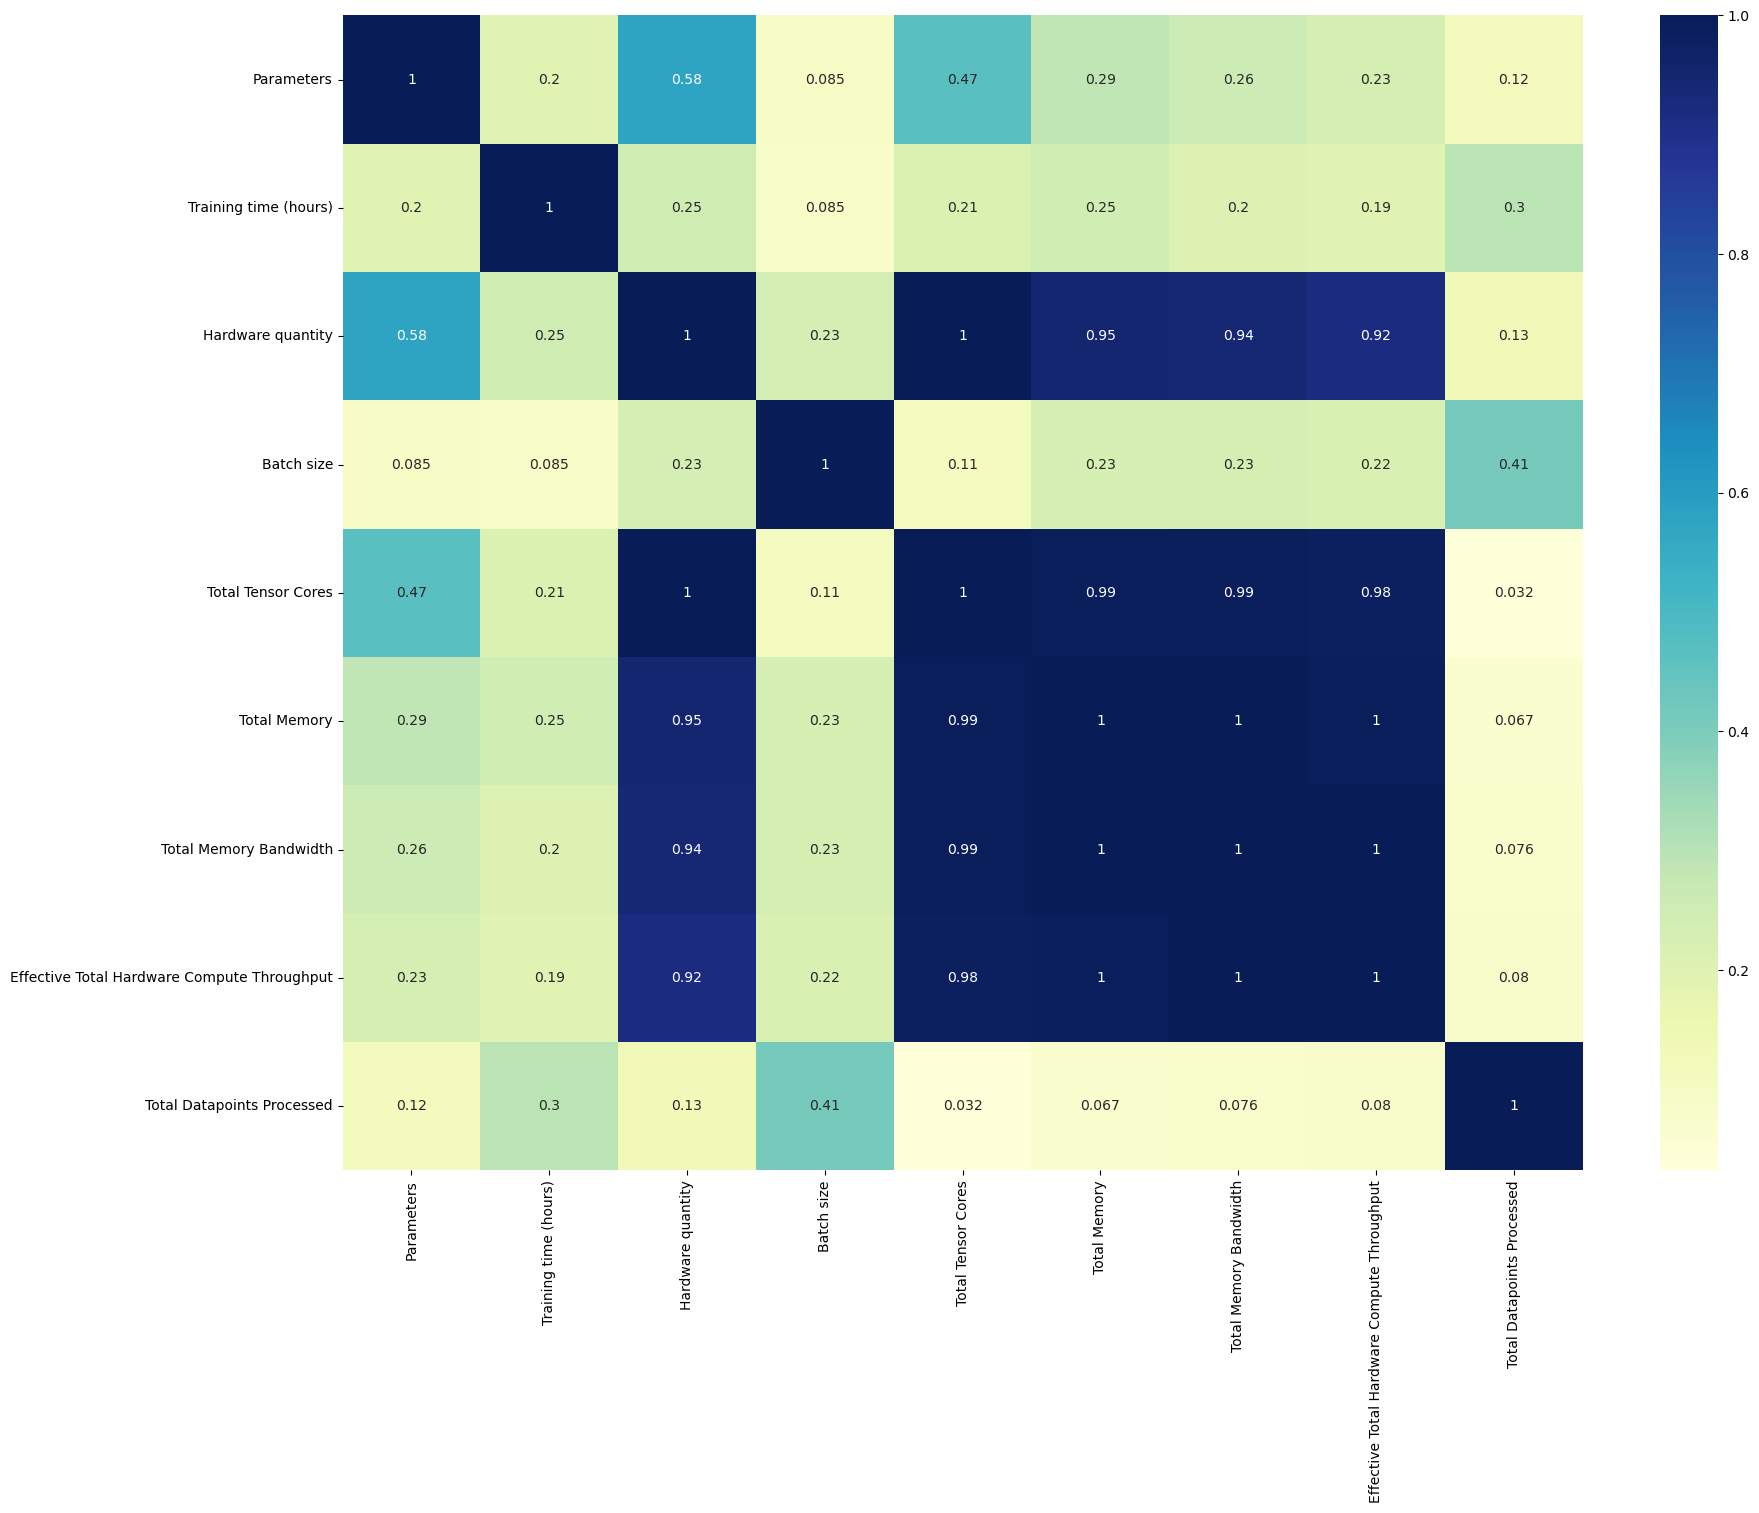

In [13]:
plt.figure(figsize=(20,15))
dataplot = sns.heatmap(trainingDataset.corr(numeric_only=True), cmap="YlGnBu", annot=True)
#sns.pairplot(trainingDataset)

In [14]:
trainingDataset = (
    trainingDataset.drop(columns=[
      'Total Tensor Cores',
      'Total Memory',
      'Total Memory Bandwidth',
      'Batch size',
      'Hardware quantity'
       ]) 
)

preLogTrainingDataset = trainingDataset.copy()

In [15]:
trainingDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Parameters                                   633 non-null    float64
 1   Training time (hours)                        221 non-null    float64
 2   Effective Total Hardware Compute Throughput  184 non-null    float64
 3   Total Datapoints Processed                   516 non-null    float64
dtypes: float64(4)
memory usage: 29.9 KB


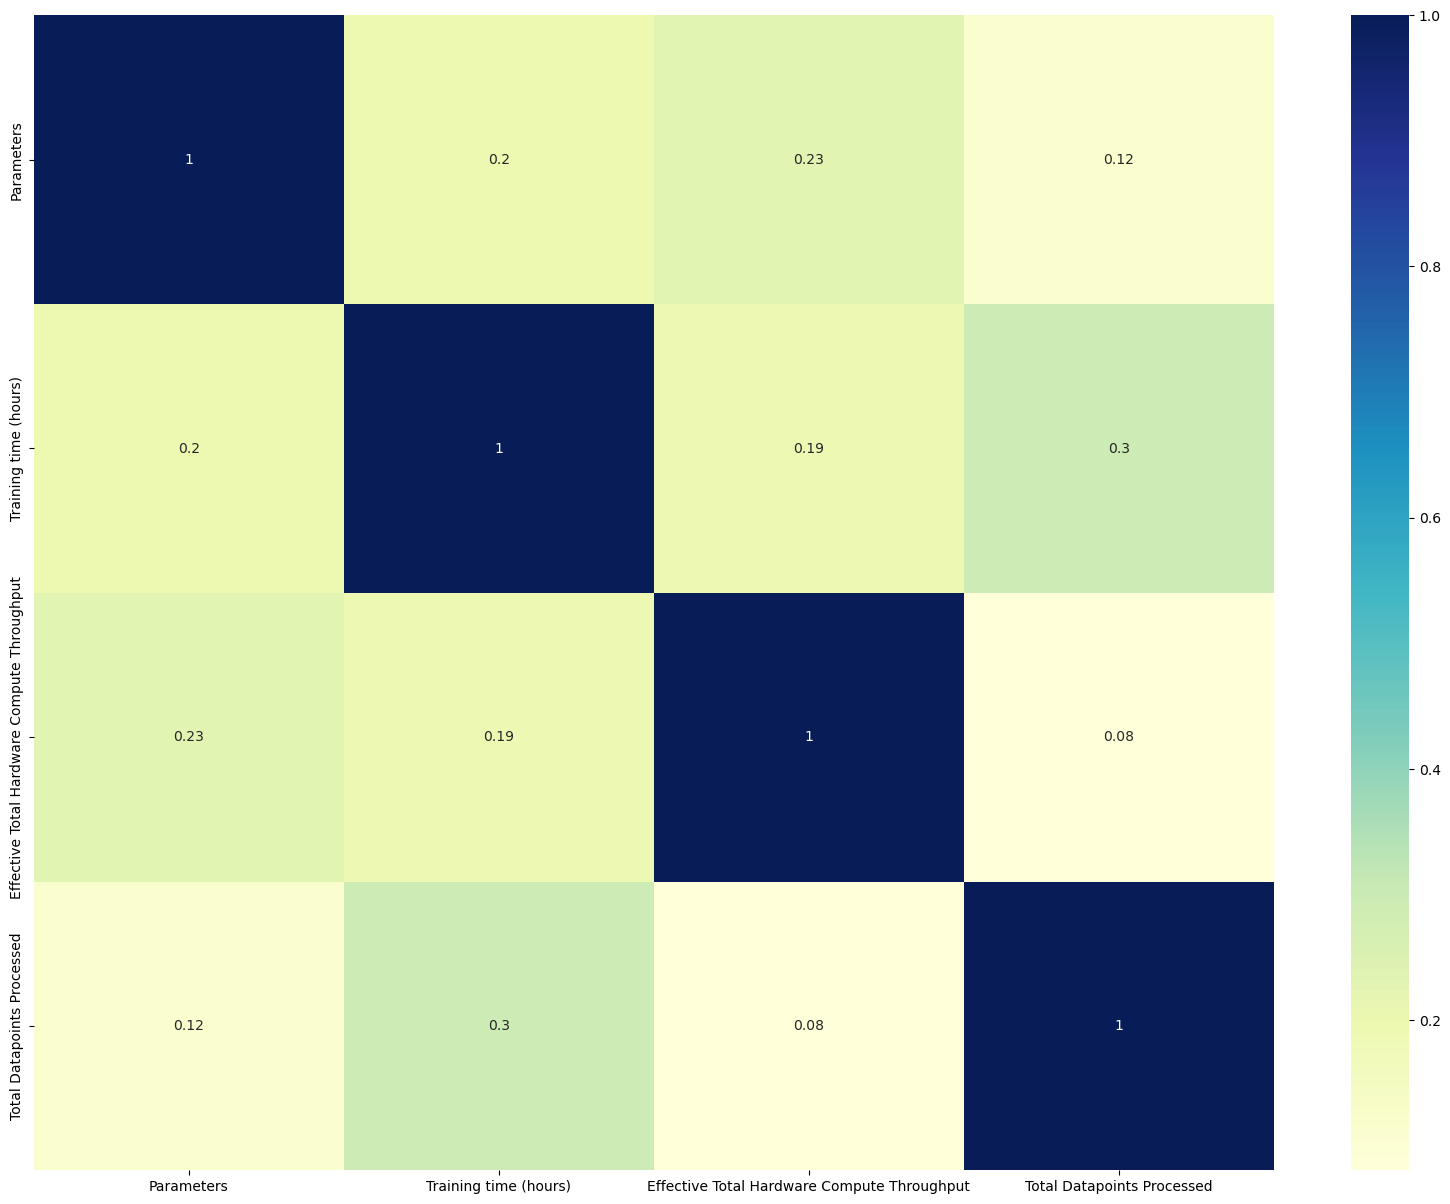

In [16]:
plt.figure(figsize=(20,15))
dataplot = sns.heatmap(trainingDataset.corr(numeric_only=True), cmap="YlGnBu", annot=True)
#sns.pairplot(trainingDataset)

### Parameters

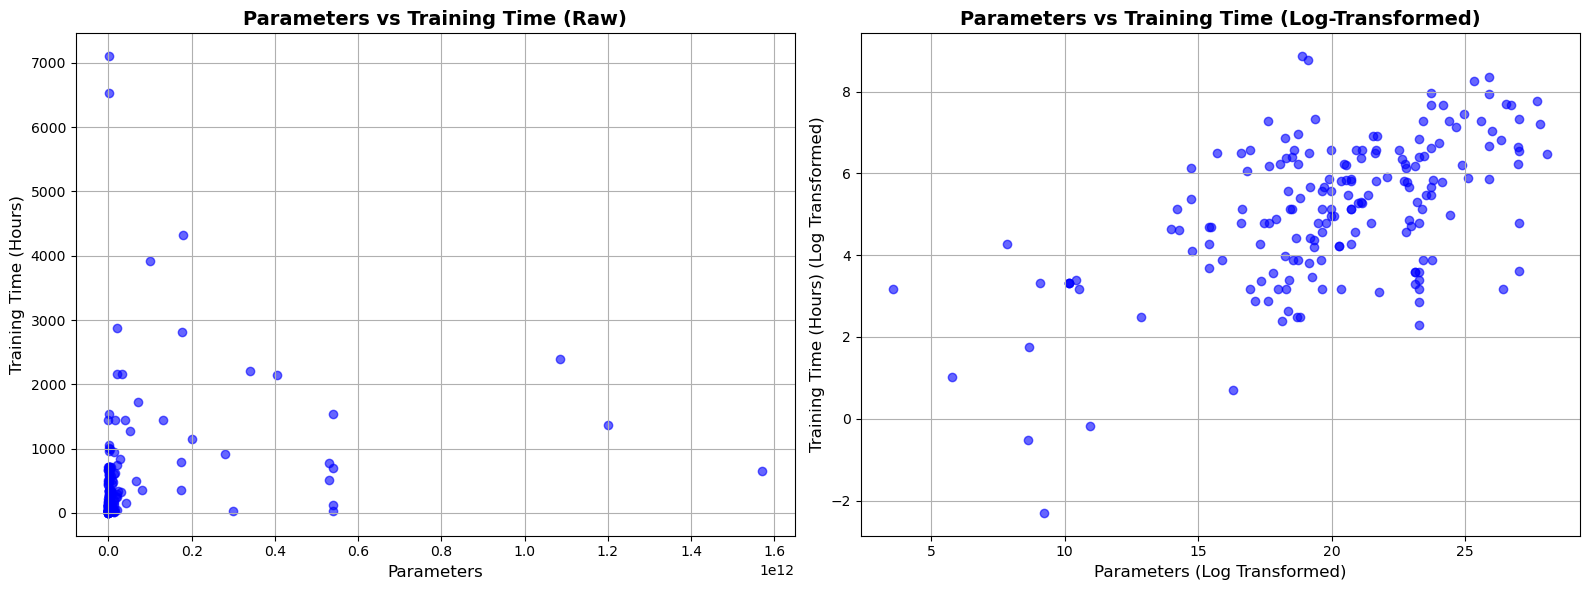

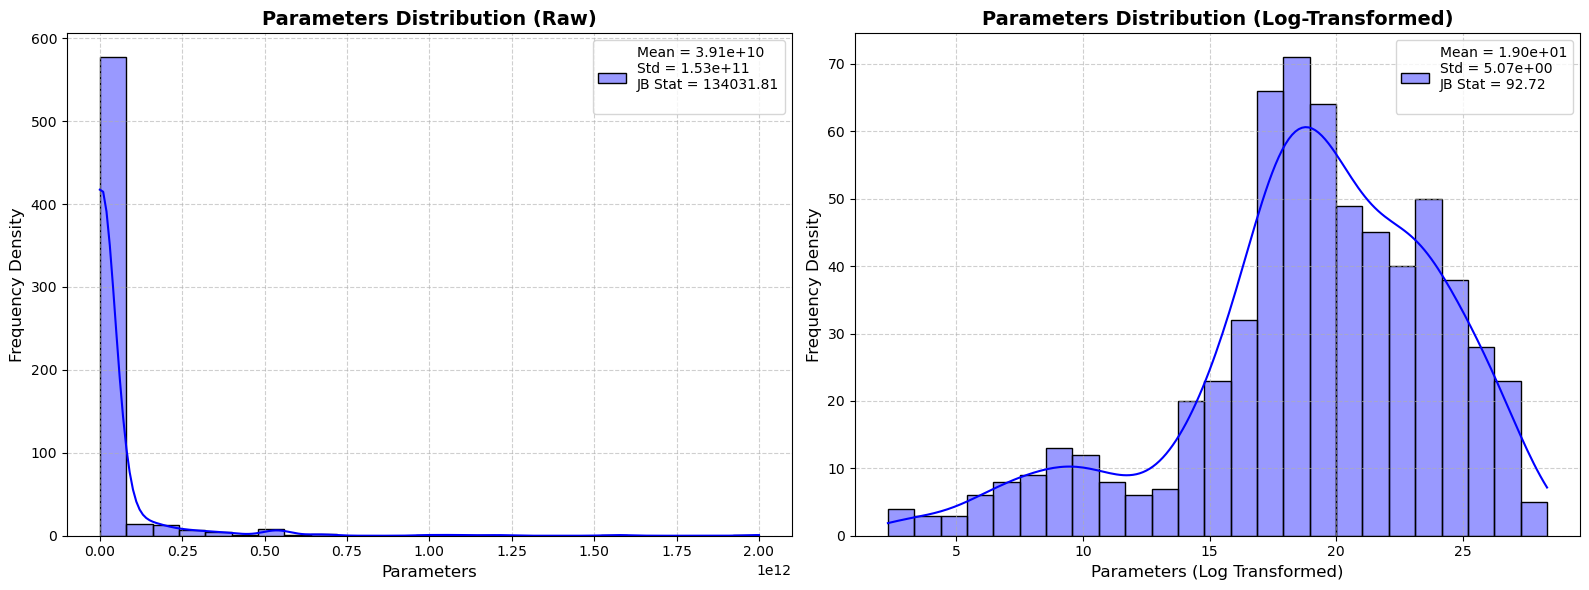

In [17]:
plotRawAndLogScatter(
    yData=trainingDataset['Training time (hours)'],
    xData=trainingDataset['Parameters'],
    yLabel='Training Time (Hours)',
    xLabel='Parameters',
    title='Parameters vs Training Time'
)

plotDistribution(
    dataSeries=trainingDataset['Parameters'],
    title='Parameters Distribution'
)


## Total Datapoints Processed

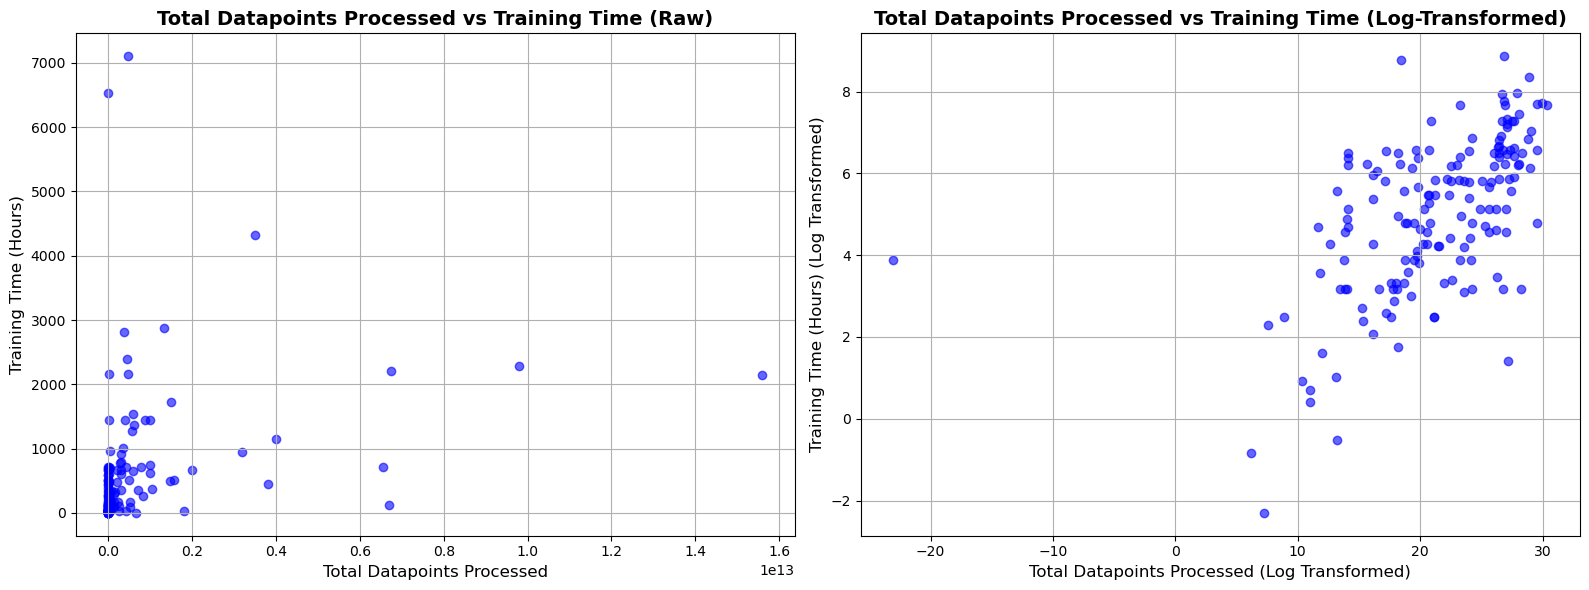

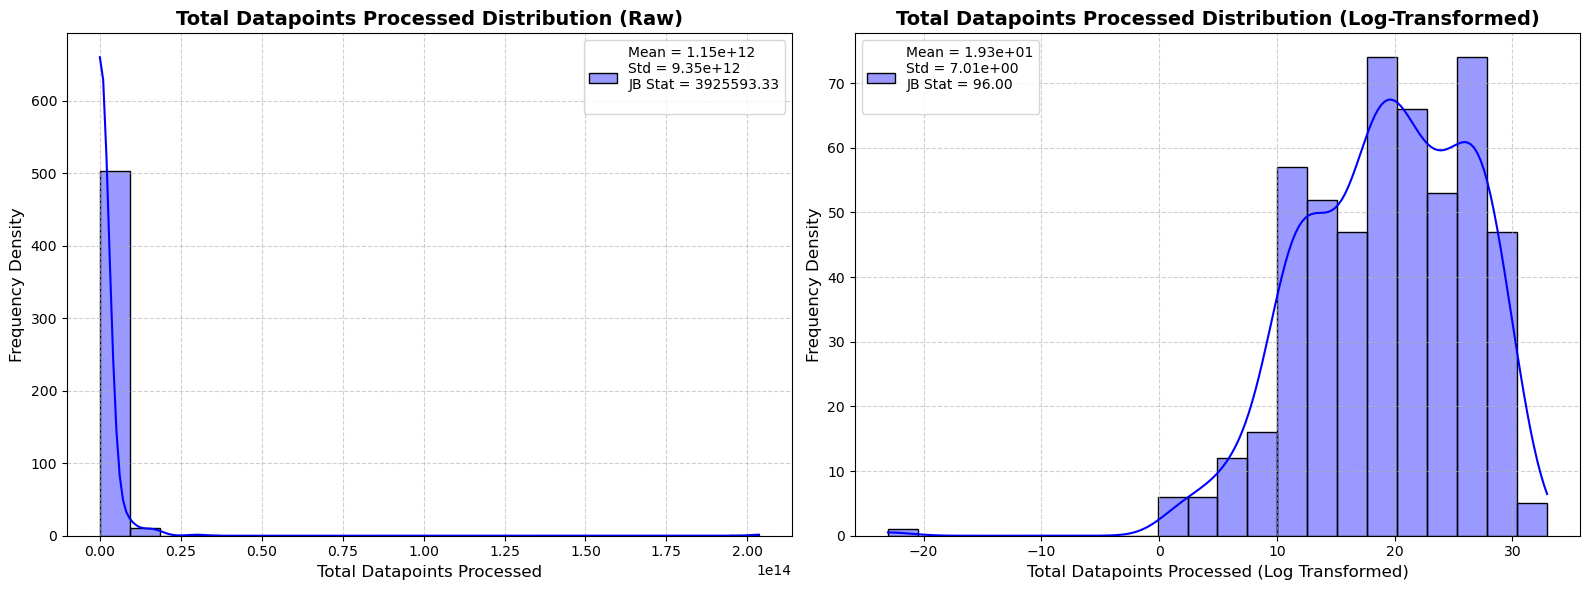

In [18]:
plotRawAndLogScatter(
    yData=trainingDataset['Training time (hours)'],
    xData=trainingDataset['Total Datapoints Processed'],
    yLabel='Training Time (Hours)',
    xLabel='Total Datapoints Processed',
    title='Total Datapoints Processed vs Training Time'
)

plotDistribution(
    dataSeries=trainingDataset['Total Datapoints Processed'],
    title='Total Datapoints Processed Distribution'
)


## Total Effective Throughput

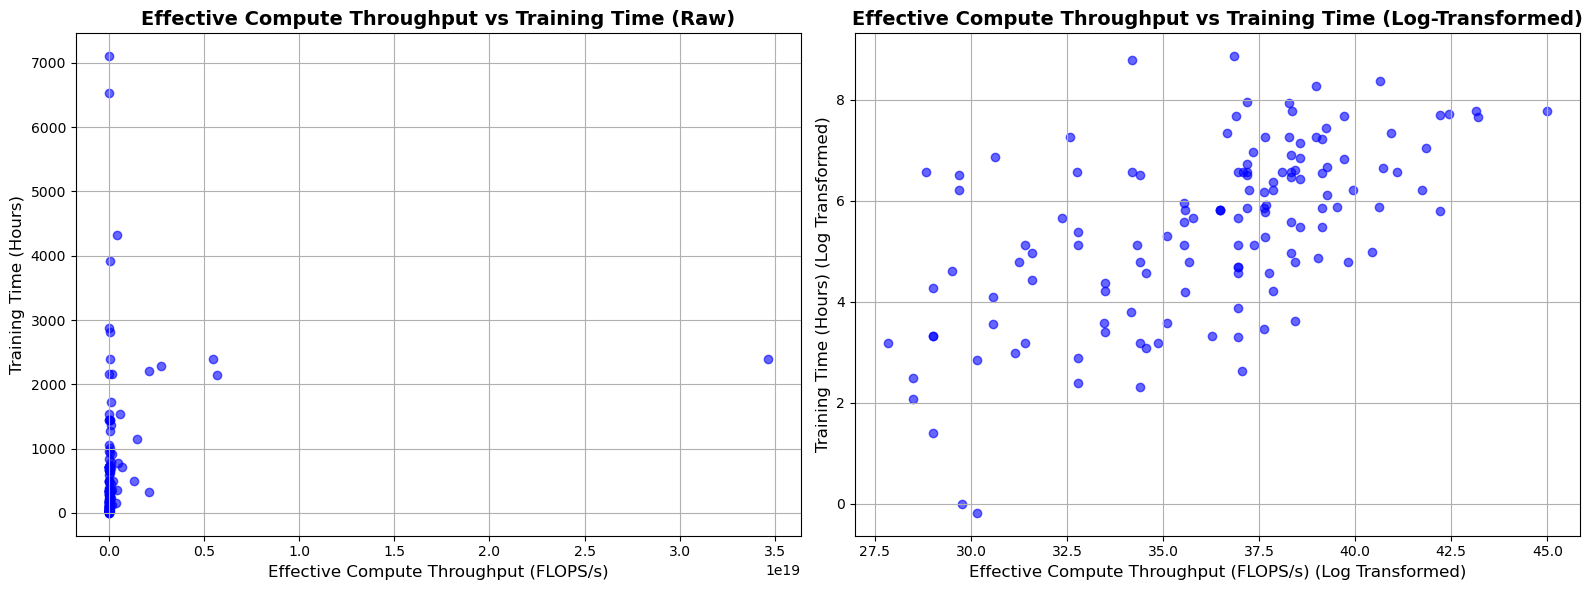

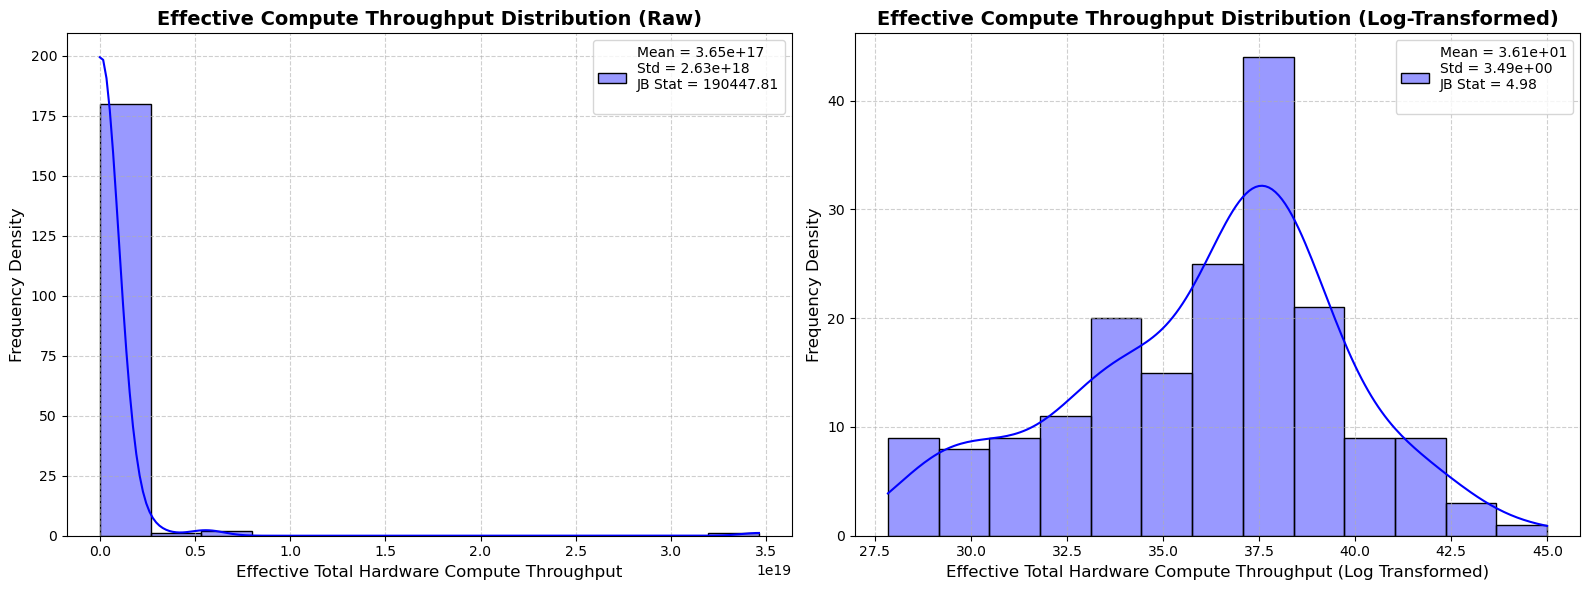

In [19]:
plotRawAndLogScatter(
    yData=trainingDataset['Training time (hours)'],
    xData=trainingDataset['Effective Total Hardware Compute Throughput'],
    yLabel='Training Time (Hours)',
    xLabel='Effective Compute Throughput (FLOPS/s)',
    title='Effective Compute Throughput vs Training Time'
)

plotDistribution(
    dataSeries=trainingDataset['Effective Total Hardware Compute Throughput'],
    title='Effective Compute Throughput Distribution'
)

### Training Time

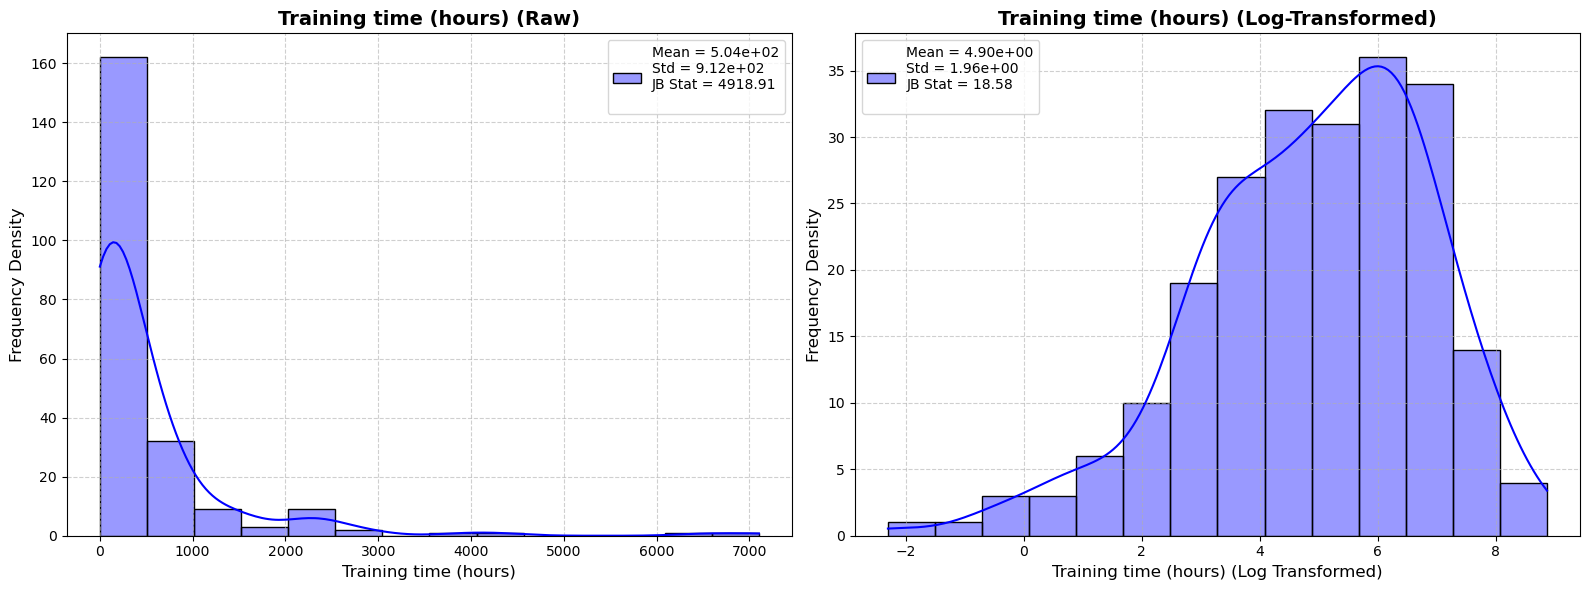

In [20]:
plotDistribution(
    dataSeries=trainingDataset['Training time (hours)'],
    title='Training time (hours)'
)


### Log Normalise Identified Features in Dataset

In [21]:
#log transform data which are succeptible to large skews in data
trainingDataset['logParameters'] = np.log1p(mergedDataset['Parameters'])
#trainingDataset['logDatasetSize'] = np.log1p(mergedDataset['Training dataset size (datapoints)'])
trainingDataset['logTotalHardwareCompute'] = np.log1p(mergedDataset['Total Hardware Compute Throughput'])
trainingDataset['logTotalMemory'] = np.log1p(mergedDataset['Total Memory Bandwidth'])
trainingDataset['logTrainingTime'] = np.log1p(mergedDataset['Training time (hours)'])
trainingDataset['logHardwareQuantity'] = np.log1p(mergedDataset['Hardware quantity'])
trainingDataset['logEpochs'] = np.log1p(mergedDataset['Epochs'])
trainingDataset['logTotalDatapointsProcessed'] = np.log1p(mergedDataset['Total Datapoints Processed'])


#drop non log tranformed data

trainingDataset = (
    trainingDataset.drop(columns=[
      'logTotalMemory',                                     
      'logHardwareQuantity',               
      'logEpochs',
      'Effective Total Hardware Compute Throughput', 
      'Parameters',                          
      #'Training dataset size (datapoints)',  
      'Training time (hours)',
      'Total Datapoints Processed'
       ]) 
)

trainingDataset


,logParameters,logTotalHardwareCompute,logTrainingTime,logTotalDatapointsProcessed
0,NaN,NaN,NaN,NaN
1,25.628541,42.571524,NaN,30.211238
2,28.324168,NaN,NaN,31.032218
3,24.189002,40.766444,7.678326,23.208172
4,NaN,NaN,NaN,NaN
...,...,...,...,...
948,NaN,NaN,NaN,NaN
949,5.420535,NaN,NaN,5.549076
950,NaN,NaN,NaN,NaN
951,3.713572,NaN,NaN,NaN


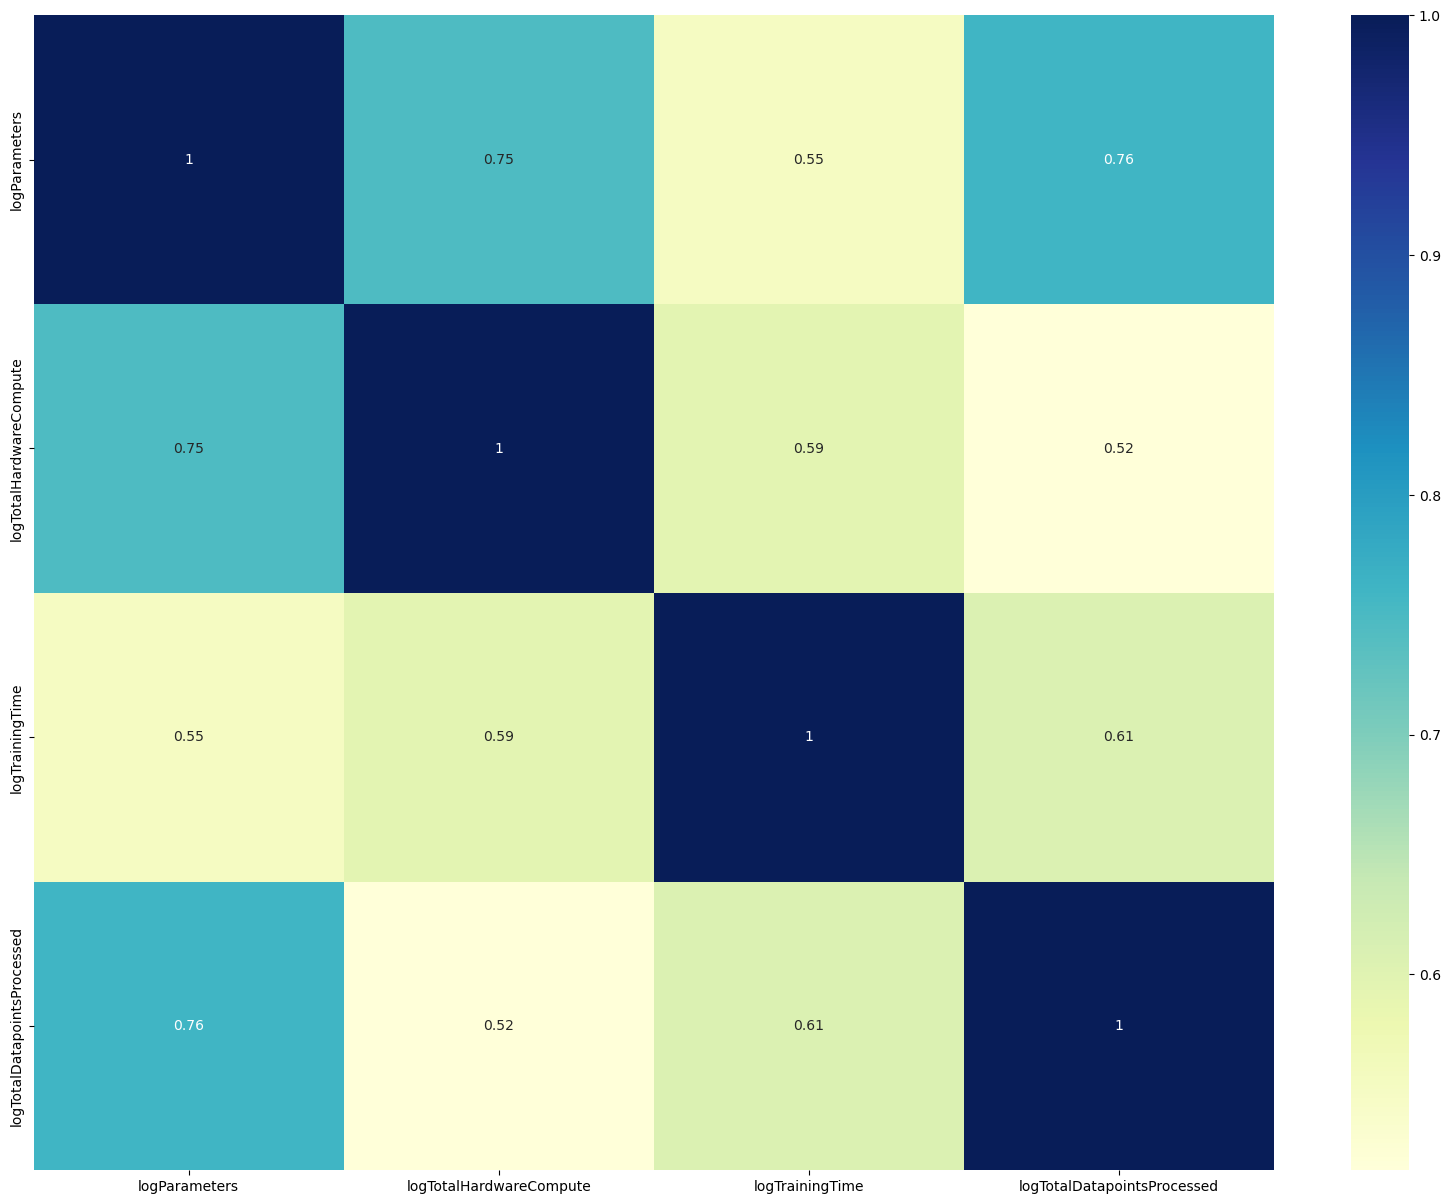

In [22]:
plt.figure(figsize=(20,15))
dataplot = sns.heatmap(trainingDataset.corr(numeric_only=True), cmap="YlGnBu", annot=True)

## Handling Missing Values

In [23]:
pd.set_option('display.max_rows', 100) 
round((trainingDataset.isnull().sum()/mergedDataset.shape[0])*100,2)

logParameters                  33.58
logTotalHardwareCompute        80.69
logTrainingTime                76.81
logTotalDatapointsProcessed    45.86
dtype: float64

## Final Training Datasets

### Datasets Without Missing Values Imputation

In [24]:
#raw values
rawTrainingDatasetNoImpute = preLogTrainingDataset.copy()
rawTrainingDatasetNoImpute = rawTrainingDatasetNoImpute.dropna(subset=['Training time (hours)'])
#log values
logTrainingDatasetNoImpute = trainingDataset.copy()
logTrainingDatasetNoImpute = logTrainingDatasetNoImpute.dropna(subset=['logTrainingTime'])

display(rawTrainingDatasetNoImpute)
display(logTrainingDatasetNoImpute)

,Parameters,Training time (hours),Effective Total Hardware Compute Throughput,Total Datapoints Processed
3,3.200000e+10,2160.0000,1.773005e+17,1.200000e+10
12,NaN,2400.0000,3.462900e+19,NaN
18,8.930000e+09,130.5000,8.865024e+16,NaN
39,NaN,720.0000,6.925800e+17,NaN
40,NaN,720.0000,1.397760e+16,NaN
...,...,...,...,...
912,1.000000e+04,0.1000,NaN,1.400000e+03
923,3.240000e+02,2.8000,NaN,5.000000e+05
937,NaN,3.0000,NaN,NaN
938,NaN,2.5000,NaN,NaN


,logParameters,logTotalHardwareCompute,logTrainingTime,logTotalDatapointsProcessed
3,24.189002,40.766444,7.678326,23.208172
12,NaN,46.041045,7.783641,NaN
18,22.912682,40.073297,4.879007,NaN
39,NaN,42.129022,6.580639,NaN
40,NaN,38.226055,6.580639,NaN
...,...,...,...,...
912,9.210440,NaN,0.095310,7.244942
923,5.783825,NaN,1.335001,13.122365
937,NaN,NaN,1.386294,NaN
938,NaN,NaN,1.252763,NaN


### Imputed Missing Values Datasets

In [ ]:
#raw values
rawTrainingDatasetNoImpute = preLogTrainingDataset.copy()
rawTrainingDatasetNoImpute = rawTrainingDatasetNoImpute.dropna(subset=['Training time (hours)'])
#impute missing values
imputer = KNNImputer(n_neighbors=2)
rawTrainingDatasetImputed = pd.DataFrame(
    imputer.fit_transform(rawTrainingDatasetNoImpute),
    columns=rawTrainingDatasetNoImpute.columns,
    index=rawTrainingDatasetNoImpute.index
)

#log values
logTrainingDatasetImputed = rawTrainingDatasetImputed.copy()
logTrainingDatasetImputed['logParameters'] = np.log1p(rawTrainingDatasetImputed['Parameters'])
logTrainingDatasetImputed['logTotalDatapointsProcessed'] = np.log1p(rawTrainingDatasetImputed['Total Datapoints Processed'])
logTrainingDatasetImputed['logTotalHardwareCompute'] = np.log1p(rawTrainingDatasetImputed['Effective Total Hardware Compute Throughput'])
logTrainingDatasetImputed['logTrainingTime'] = np.log1p(rawTrainingDatasetImputed['Training time (hours)'])
logTrainingDatasetImputed = (
    logTrainingDatasetImputed.drop(columns=[
      'Effective Total Hardware Compute Throughput', 
      'Parameters',                          
      'Total Datapoints Processed',
      'Training time (hours)'
       ]) 
)

display(rawTrainingDatasetImputed)
display(logTrainingDatasetImputed)

,Parameters,Training time (hours),Effective Total Hardware Compute Throughput,Total Datapoints Processed
3,3.200000e+10,2160.0000,1.773005e+17,1.200000e+10
12,1.400000e+10,2400.0000,3.462900e+19,1.152000e+11
18,8.930000e+09,130.5000,8.865024e+16,5.000035e+10
39,1.400000e+10,720.0000,6.925800e+17,1.500000e+11
40,1.400000e+10,720.0000,1.397760e+16,1.500000e+11
...,...,...,...,...
912,1.000000e+04,0.1000,1.766079e+19,1.400000e+03
923,3.240000e+02,2.8000,1.766079e+19,5.000000e+05
937,2.046500e+10,3.0000,1.740315e+19,1.930000e+10
938,2.046500e+10,2.5000,1.740315e+19,1.930000e+10


,logParameters,logTotalDatapointsProcessed,logTotalHardwareCompute,logTrainingTime
3,24.189002,23.208172,39.716622,7.678326
12,23.362323,25.469936,44.991223,7.783641
18,22.912682,24.635296,39.023475,4.879007
39,23.362323,25.733901,41.079200,6.580639
40,23.362323,25.733901,37.176232,6.580639
...,...,...,...,...
912,9.210440,7.244942,44.317879,0.095310
923,5.783825,13.122365,44.317879,1.335001
937,23.741982,23.683371,44.303183,1.386294
938,23.741982,23.683371,44.303183,1.252763


# Model Training

## Non-Linear Models on Raw Values 

In [26]:
resultsnonLinearRaw = [] #to store performance results
resultsnonLinearLogUntuned = [] #to store performance results
resultsnonLinearLogTuned = [] #to store performance results

### Random Forest (raw values)

In [27]:
rawRandomForestX = rawTrainingDatasetImputed.drop(columns=['Training time (hours)'])
rawRandomForestY = rawTrainingDatasetImputed['Training time (hours)'] 

#display(rawRandomForestX)
#display(rawRandomForestY)

rf = RandomForestRegressor(random_state=42) #random states for reproducible results

#5f cross val
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(rf, rawRandomForestX, rawRandomForestY, cv=kf, scoring='r2')
medae_scores = cross_val_score(rf, rawRandomForestX, rawRandomForestY, cv=kf, scoring='neg_median_absolute_error')
medape_scores = cross_val_score(rf, rawRandomForestX, rawRandomForestY, cv=kf, scoring=medape_scorer)

print("Random Forest 5-Fold CV:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {-np.mean(medae_scores):.2f} hours")

print(f"MedAE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedPAE: {np.mean(medape_scores):.2f} %")

resultsnonLinearRaw.append({
    'Model': 'Random Forest (Raw Data)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': -np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

Random Forest 5-Fold CV:
R² scores: [0.0638, 0.1173, -0.3624, -0.0222, 0.2195]
Average R²: 0.0032

MedAE scores: [-269.84, -267.86, -234.49, -262.36, -201.27]
Average MedAE: 247.17 hours
MedAE scores: [91.87, 156.08, 277.75, 74.78, 119.1]
Average MedPAE: 143.91 %


### XGBoost (raw values)

In [28]:
rawXGBoostX = rawTrainingDatasetNoImpute.drop(columns=['Training time (hours)'])
rawXGBoostY = rawTrainingDatasetNoImpute['Training time (hours)'] 

#display(rawXGBoostX)
#display(rawXGBoostY)

xgb_regressor_time = xgb.XGBRegressor(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(xgb_regressor_time, rawXGBoostX, rawXGBoostY, cv=kf, scoring='r2')
medae_scores = cross_val_score(xgb_regressor_time, rawXGBoostX, rawXGBoostY, cv=kf, scoring='neg_median_absolute_error')
medape_scores = cross_val_score(xgb_regressor_time, rawXGBoostX, rawXGBoostY, cv=kf, scoring=medape_scorer)

print("XGBoost 5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {-np.mean(medae_scores):.2f} hours")

print(f"MedAE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsnonLinearRaw.append({
    'Model': 'XGBoost (Raw Data)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': -np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

XGBoost 5-Fold Cross-Validation Metrics:
R² scores: [0.0447, -0.299, -2.5967, -0.0659, -0.017]
Average R²: -0.5868

MedAE scores: [-227.41, -126.43, -218.43, -204.35, -162.67]
Average MedAE: 187.86 hours
MedAE scores: [74.27, 68.6, 275.38, 73.13, 81.79]
Average MedAPE: 114.63 %


In [29]:
resultsnonLinearRaw

[{'Model': 'Random Forest (Raw Data)',
  'Average R²': 0.0031962854799491903,
  'Average MedAE': 247.16505714285705,
  'Average MedAPE': 143.91372515717748},
 {'Model': 'XGBoost (Raw Data)',
  'Average R²': -0.5867706733835586,
  'Average MedAE': 187.8585235595703,
  'Average MedAPE': 114.63388906456548}]

### Random Forest Regression with Log Tranformed Data

In [30]:
logRandomForestX = logTrainingDatasetImputed.drop(columns=['logTrainingTime'])
logRandomForestY = logTrainingDatasetImputed['logTrainingTime'] 

#display(logRandomForestX)
#display(logRandomForestY)

rf = RandomForestRegressor(random_state=42)           
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logRandomForestX):
    X_train = logRandomForestX.iloc[trainIdx]
    X_test = logRandomForestX.iloc[testIdx]
    y_train = logRandomForestY.iloc[trainIdx]
    y_test = logRandomForestY.iloc[testIdx]

    rf.fit(X_train, y_train)
    y_pred_log = rf.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsnonLinearLogUntuned.append({
    'Model': 'Random Forest (Log Transformed Untuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [0.0931, 0.1316, -0.0532, -0.095, -0.0426]
Average R²: 0.0068

MedAE scores: [205.0, 114.01, 115.22, 241.32, 107.81]
Average MedAE: 156.67 hours
MedAPE scores: [73.56, 73.29, 97.45, 73.84, 70.8]
Average MedAPE: 77.79 %


## Tuning Random Forest

In [31]:
logRandomForestX = logTrainingDatasetImputed.drop(columns=['logTrainingTime'])
logRandomForestY = logTrainingDatasetImputed['logTrainingTime'] 

#display(logRandomForestX)
#display(logRandomForestY)

rf = RandomForestRegressor(random_state=42)           
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logRandomForestX):
    X_train = logRandomForestX.iloc[trainIdx]
    X_test = logRandomForestX.iloc[testIdx]
    y_train = logRandomForestY.iloc[trainIdx]
    y_test = logRandomForestY.iloc[testIdx]

    rf.fit(X_train, y_train)
    y_pred_log = rf.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

def real_medae(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return median_absolute_error(y_true, y_pred)

realMedAE_scorer = make_scorer(real_medae, greater_is_better=False)

# define params grid
#https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74/
paramGrid = {
    'n_estimators': [80, 90, 100, 110, 120],
    'max_depth': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [1.0, 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# set up gridsearch
gridSearch = GridSearchCV(
    estimator=rf,
    param_grid=paramGrid,
    scoring=realMedAE_scorer,
    cv=kf,
)

#fit in log space
#gridSearch.fit(logRandomForestX, logRandomForestY)

#get best model
#bestrf = gridSearch.best_estimator_
#print("Best Hyperparameters:", gridSearch.best_params_)
#print("Best Score (MedAE):", -gridSearch.best_score_)

bestrf = RandomForestRegressor( #replace wuth bets hyper papams
    max_depth = None, 
    max_features = 'sqrt', 
    min_samples_leaf = 2, 
    min_samples_split = 6, 
    n_estimators = 90
)
r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logRandomForestX):
    X_train = logRandomForestX.iloc[trainIdx]
    X_test = logRandomForestX.iloc[testIdx]
    y_train = logRandomForestY.iloc[trainIdx]
    y_test = logRandomForestY.iloc[testIdx]

    bestrf.fit(X_train, y_train)
    y_pred_log = bestrf.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsnonLinearLogUntuned.append({
    'Model': 'Random Forest (Log Transformed Tuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [0.0931, 0.1316, -0.0532, -0.095, -0.0426]
Average R²: 0.0068

MedAE scores: [205.0, 114.01, 115.22, 241.32, 107.81]
Average MedAE: 156.67 hours
MedAPE scores: [73.56, 73.29, 97.45, 73.84, 70.8]
Average MedAPE: 77.79 %
5-Fold Cross-Validation Metrics:
R² scores: [0.0574, 0.0852, -0.0521, -0.079, 0.046]
Average R²: 0.0115

MedAE scores: [119.95, 141.63, 124.48, 197.98, 82.52]
Average MedAE: 133.31 hours
MedAPE scores: [66.03, 74.32, 110.54, 67.23, 60.59]
Average MedAPE: 75.74 %


### XGBoost (Log Transformed Data)

In [32]:
#prep data

logXGBoostX = logTrainingDatasetNoImpute.drop(columns=['logTrainingTime'])
logXGBoostY = logTrainingDatasetNoImpute['logTrainingTime'] 

#display(logXGBoostX)
#display(logXGBoostY)

#train model and evaluate

xgb_regressor_time = xgb.XGBRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logXGBoostX):
    X_train = logXGBoostX.iloc[trainIdx]
    X_test = logXGBoostX.iloc[testIdx]
    y_train = logXGBoostY.iloc[trainIdx]
    y_test = logXGBoostY.iloc[testIdx]

    xgb_regressor_time.fit(X_train, y_train)
    y_pred_log = xgb_regressor_time.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsnonLinearLogUntuned.append({
    'Model': 'XGBoost (Log Transformed Untuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

print(xgb_regressor_time.get_params())

5-Fold Cross-Validation Metrics:
R² scores: [0.0131, 0.0514, -0.1394, -0.2226, 0.3139]
Average R²: 0.0033

MedAE scores: [184.7, 166.76, 164.31, 194.15, 131.06]
Average MedAE: 168.19 hours
MedAPE scores: [74.92, 75.56, 153.92, 76.28, 69.37]
Average MedAPE: 90.01 %
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': N

## Tuning XGBoost

In [33]:
#prep data

logXGBoostX = logTrainingDatasetNoImpute.drop(columns=['logTrainingTime'])
logXGBoostY = logTrainingDatasetNoImpute['logTrainingTime'] 

#display(logXGBoostX)
#display(logXGBoostY)

#train model and evaluate

xgb_regressor_time = xgb.XGBRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logXGBoostX):
    X_train = logXGBoostX.iloc[trainIdx]
    X_test = logXGBoostX.iloc[testIdx]
    y_train = logXGBoostY.iloc[trainIdx]
    y_test = logXGBoostY.iloc[testIdx]

    xgb_regressor_time.fit(X_train, y_train)
    y_pred_log = xgb_regressor_time.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

def real_medae(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return median_absolute_error(y_true, y_pred)

realMedAE_scorer = make_scorer(real_medae, greater_is_better=False)

# define params grid
#https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/
#https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
#https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
# https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

paramGrid = {
    'n_estimators': [50, 75, 100, 150, 200, 250, 300, 350],       
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, 15],                     
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9],          
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],                   
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.9, 1.0],           
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2, 5],                     
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1, 2, 5]                     
}

xgboost = xgb.XGBRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# set up gridsearch
randomSearch = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=paramGrid,
    scoring=realMedAE_scorer,
    cv=kf,
)

#fit in log space
#randomSearch.fit(logXGBoostX, logXGBoostY)

#get best model
#estxgb = randomSearch.best_estimator_
#print("Best Hyperparameters:", randomSearch.best_params_)
#print("Best Score (MedAE):", -randomSearch.best_score_)

r2_scores = []
medae_scores = []
medape_scores = []

bestxgb = xgb.XGBRegressor( ##replace with best search huper paprams
    subsample = 0.5, 
    reg_lambda = 0.01, 
    reg_alpha = 5, 
    n_estimators = 160, 
    max_depth = 12, 
    learning_rate = 0.1, 
    colsample_bytree =0.9
)
#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logXGBoostX):
    X_train = logXGBoostX.iloc[trainIdx]
    X_test = logXGBoostX.iloc[testIdx]
    y_train = logXGBoostY.iloc[trainIdx]
    y_test = logXGBoostY.iloc[testIdx]

    bestxgb.fit(X_train, y_train)
    y_pred_log = bestxgb.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsnonLinearLogUntuned.append({
    'Model': 'XGBoost (Log Transformed Tuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [0.0131, 0.0514, -0.1394, -0.2226, 0.3139]
Average R²: 0.0033

MedAE scores: [184.7, 166.76, 164.31, 194.15, 131.06]
Average MedAE: 168.19 hours
MedAPE scores: [74.92, 75.56, 153.92, 76.28, 69.37]
Average MedAPE: 90.01 %
5-Fold Cross-Validation Metrics:
R² scores: [0.1186, 0.156, -0.12, -0.038, 0.3641]
Average R²: 0.0961
MedAE scores: [149.88, 88.68, 145.8, 184.03, 105.26]
Average MedAE: 134.73 hours
MedAPE scores: [71.56, 71.75, 96.91, 75.56, 63.62]
Average MedAPE: 75.88 %


# Linear Models with different levels of regularisation on Raw Data

### Data Preparation (raw values)

In [34]:
rawlinearModelsX = rawTrainingDatasetImputed.drop(columns=['Training time (hours)'])
rawlinearModelsY = rawTrainingDatasetImputed['Training time (hours)']

#display(rawlinearModelsX)
#display(rawlinearModelsY)

resultsLinearRaw = [] #to store performance results

## Linear Regression

In [35]:
# initialise model
linear = LinearRegression()

# 5-fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross-val
r2_scores = cross_val_score(linear, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='r2')
medae_scores = cross_val_score(linear, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='neg_median_absolute_error')
medape_scores = cross_val_score(linear, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring=medape_scorer)

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")
print(f"MedAE scores: {[-round(s, 2) for s in medae_scores]}")
print(f"Average MedAE: {-np.mean(medae_scores):.2f} hours")
print(f"MedAPE scores: {[round(s, 2) for s in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsLinearRaw.append({
    'Model': 'Linear (Raw Data)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': -np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [0.057, 0.0843, -0.351, 0.1288, -0.1547]
Average R²: -0.0471

MedAE scores: [242.55, 376.7, 469.57, 376.68, 198.08]
Average MedAE: 332.72 hours
MedAPE scores: [92.76, 256.39, 394.23, 66.72, 166.59]
Average MedAPE: 195.34 %


### Ridge Regression

In [36]:
# initialise model and 5f cross val
ridge = Ridge()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross val
r2_scores = cross_val_score(ridge, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='r2')
medae_scores = cross_val_score(ridge, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='neg_median_absolute_error')
medape_scores = cross_val_score(ridge, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring=medape_scorer)

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")
print(f"MedAE scores: {[-round(s, 2) for s in medae_scores]}")
print(f"Average MedAE: {-np.mean(medae_scores):.2f} hours")
print(f"MedAPE scores: {[round(s, 2) for s in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsLinearRaw.append({
    'Model': 'Ridge (Raw Data)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': -np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [0.057, 0.0843, -0.351, 0.1288, -0.1547]
Average R²: -0.0471

MedAE scores: [242.55, 376.7, 469.57, 376.68, 198.08]
Average MedAE: 332.72 hours
MedAPE scores: [92.76, 256.39, 394.23, 66.72, 166.59]
Average MedAPE: 195.34 %


### LASSO Regression

In [37]:
# initialise model and 5f cross val
lasso = Lasso()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross val
r2_scores = cross_val_score(lasso, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='r2')
medae_scores = cross_val_score(lasso, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='neg_median_absolute_error')
medape_scores = cross_val_score(lasso, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring=medape_scorer)


print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")
print(f"MedAE scores: {[-round(s, 2) for s in medae_scores]}")
print(f"Average MedAE: {-np.mean(medae_scores):.2f} hours")
print(f"MedAPE scores: {[-round(s, 2) for s in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsLinearRaw.append({
    'Model': 'LASSO (Raw Data)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': -np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})


5-Fold Cross-Validation Metrics:
R² scores: [0.057, 0.0843, -0.351, 0.1288, -0.1547]
Average R²: -0.0471

MedAE scores: [242.55, 376.7, 469.57, 376.68, 198.08]
Average MedAE: 332.72 hours
MedAPE scores: [-92.76, -256.39, -394.23, -66.72, -166.59]
Average MedAPE: 195.34 %


Elastic Net Regression

In [38]:
# initialise model and 5f cross val
elasticNet = ElasticNet()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross val
r2_scores = cross_val_score(elasticNet, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='r2')
medae_scores = cross_val_score(elasticNet, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring='neg_median_absolute_error')
medape_scores = cross_val_score(elasticNet, rawlinearModelsX, rawlinearModelsY, cv=kf, scoring=medape_scorer)

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")
print(f"MedAE scores: {[-round(s, 2) for s in medae_scores]}")
print(f"Average MedAE: {-np.mean(medae_scores):.2f} hours")
print(f"MedAPE scores: {[round(s, 2) for s in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsLinearRaw.append({
    'Model': 'Elastic Net (Raw Data)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': -np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [0.057, 0.0843, -0.351, 0.1288, -0.1547]
Average R²: -0.0471

MedAE scores: [242.55, 376.7, 469.57, 376.68, 198.08]
Average MedAE: 332.72 hours
MedAPE scores: [92.76, 256.39, 394.23, 66.72, 166.59]
Average MedAPE: 195.34 %


## Linear Models Raw Data Results

## Linear Models with different levels of regularisation on Log Transformed Data

### Data Preparation (log transformed values)

In [39]:
#split dataset target and inputs
logLinearModelsX = logTrainingDatasetImputed.drop(columns=['logTrainingTime'])
logLinearModelsY = logTrainingDatasetImputed['logTrainingTime']

#display(logLinearModelsX)
#display(logLinearModelsY)

resultsLinearLogTuned = []
resultsLinearLogUntuned = []

### Linear Regression

In [53]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linear = LinearRegression()

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    linear.fit(X_train, y_train) 
    y_pred_log = linear.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogUntuned.append({
    'Model': 'Linear (Log Transformed Data Untuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})


5-Fold Cross-Validation Metrics:
R² scores: [-0.0816, -0.045, -0.0095, -0.1215, -0.0035]
Average R²: -0.0522 
MedAE scores: [142.67, 204.89, 131.63, 196.34, 157.25]
Average MedAE: 166.56 hours
MedAPE scores: [65.83, 81.63, 132.84, 74.07, 81.36]
Average MedAPE: 87.15 %


### Ridge Regression

Pre-Tuning of Hyperparameters

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge = Ridge()

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    ridge.fit(X_train, y_train) 
    y_pred_log = ridge.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogUntuned.append({
    'Model': 'Ridge (Log Transformed Data Untuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

print(ridge.get_params())

5-Fold Cross-Validation Metrics:
R² scores: [-0.0816, -0.045, -0.0095, -0.1215, -0.0035]
Average R²: -0.0522 
MedAE scores: [142.69, 204.88, 131.58, 196.33, 157.25]
Average MedAE: 166.55 hours
MedAPE scores: [65.83, 81.63, 132.84, 74.08, 81.36]
Average MedAPE: 87.15 %
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


### Hyperpaprameters Tuning

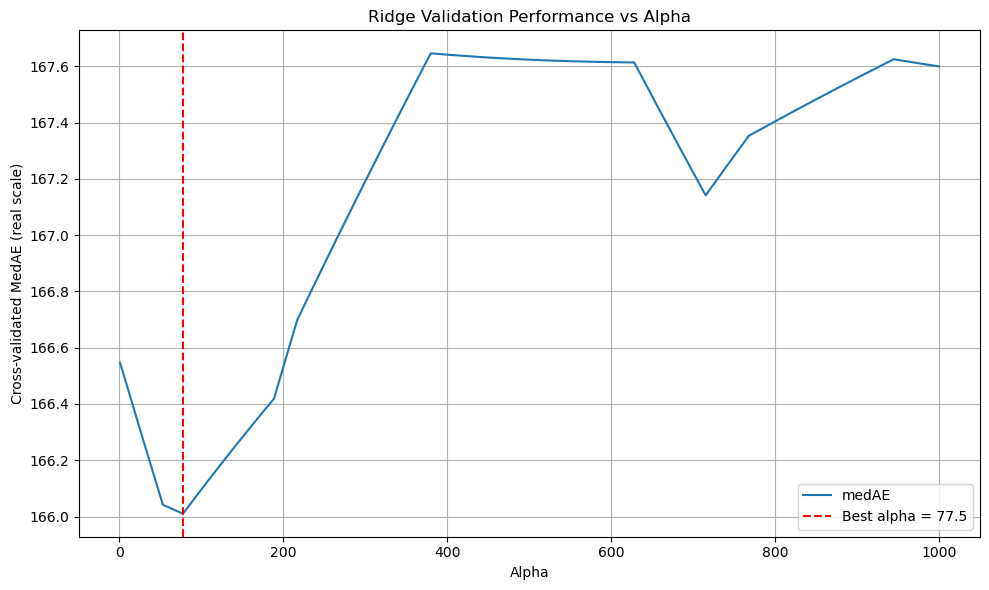

Best alpha: 77.5
Lowest MedAE: 166.0100


In [42]:
medaes = []

alphas = np.arange(1, 1000, 0.5)

for a in alphas:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    ridge = Ridge(alpha=a)
    
    medae_scores = []

    for trainIdx, testIdx in kf.split(logLinearModelsX):
        X_train = logLinearModelsX.iloc[trainIdx]
        X_test = logLinearModelsX.iloc[testIdx]
        y_train = logLinearModelsY.iloc[trainIdx]
        y_test = logLinearModelsY.iloc[testIdx]
        
        ridge.fit(X_train, y_train)           
        y_pred_log = ridge.predict(X_test)    
    
        y_true = np.expm1(y_test)
        y_pred = np.expm1(y_pred_log)
    
        medae_scores.append(median_absolute_error(y_true, y_pred))
        
    
    medaes.append(np.mean(medae_scores))  

# best alpha
best_idx = np.argmin(medaes)
best_ridge = alphas[best_idx]
lowestMedae = medaes[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(alphas, medaes, linestyle='-', label='medAE')
plt.axvline(x=best_ridge, color='red', linestyle='--', label=f"Best alpha = {best_ridge}")
plt.xlabel('Alpha')
plt.ylabel('Cross-validated MedAE (real scale)')
plt.title('Ridge Validation Performance vs Alpha')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best alpha: {best_ridge}")
print(f"Lowest MedAE: {lowestMedae:.4f}")

### Tuned Model

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge = Ridge(alpha=best_ridge)

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    ridge.fit(X_train, y_train) 
    y_pred_log = ridge.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogTuned.append({
    'Model': 'Ridge (Log Transformed Data Tuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

5-Fold Cross-Validation Metrics:
R² scores: [-0.084, -0.0476, -0.0092, -0.125, -0.0067]
Average R²: -0.0545 
MedAE scores: [143.81, 204.37, 129.06, 195.72, 157.09]
Average MedAE: 166.01 hours
MedAPE scores: [65.96, 81.57, 132.62, 74.14, 81.35]
Average MedAPE: 87.13 %


### LASSO Regression

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso = Lasso()

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    lasso.fit(X_train, y_train) 
    y_pred_log = lasso.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogUntuned.append({
    'Model': 'LASSO (Log Transformed Data Untuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

print(lasso.get_params())

5-Fold Cross-Validation Metrics:
R² scores: [-0.1305, -0.0968, -0.0058, -0.1789, -0.069]
Average R²: -0.0962 
MedAE scores: [163.09, 192.7, 109.63, 211.63, 149.63]
Average MedAE: 165.34 hours
MedAPE scores: [76.65, 89.6, 114.7, 74.26, 79.16]
Average MedAPE: 86.87 %
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


### Hyperparameter Tuning

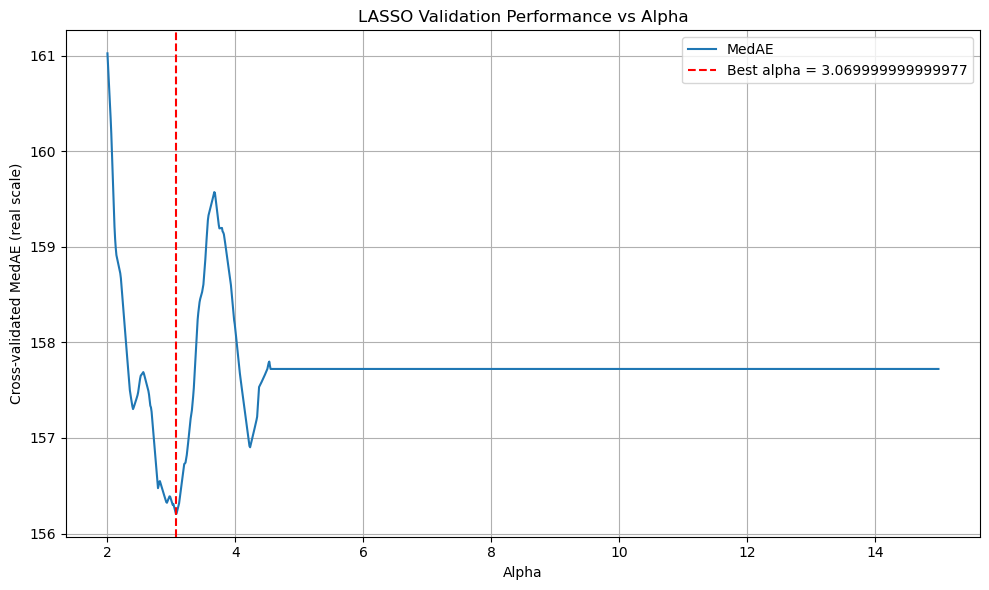

Best alpha: 3.069999999999977
Lowest MedAE: 156.2079


In [45]:
medaes = []

alphas = np.arange(2, 15, 0.01)

for a in alphas:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso = Lasso(alpha=a)
    
    medae_scores = []

    for trainIdx, testIdx in kf.split(logLinearModelsX):
        X_train = logLinearModelsX.iloc[trainIdx]
        X_test = logLinearModelsX.iloc[testIdx]
        y_train = logLinearModelsY.iloc[trainIdx]
        y_test = logLinearModelsY.iloc[testIdx]
        
        lasso.fit(X_train, y_train)           
        y_pred_log = lasso.predict(X_test)    
    
        y_true = np.expm1(y_test)
        y_pred = np.expm1(y_pred_log)
    
        medae_scores.append(median_absolute_error(y_true, y_pred))
        
    
    medaes.append(np.mean(medae_scores))  

# best alpha
best_idx = np.argmin(medaes)
best_lasso = alphas[best_idx]
lowest_medae = medaes[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(alphas, medaes, linestyle='-', label='MedAE')
plt.axvline(x=best_lasso, color='red', linestyle='--', label=f"Best alpha = {best_lasso}")
plt.xlabel('Alpha')
plt.ylabel('Cross-validated MedAE (real scale)')
plt.title('LASSO Validation Performance vs Alpha')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best alpha: {best_lasso}")
print(f"Lowest MedAE: {lowest_medae:.4f}")

### Tuned Model

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso = Lasso(alpha=best_lasso)

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    lasso.fit(X_train, y_train) 
    y_pred_log = lasso.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogTuned.append({
    'Model': 'LASSO (Log Transformed Data Tuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

print(lasso.get_params())

5-Fold Cross-Validation Metrics:
R² scores: [-0.1899, -0.1501, -0.0385, -0.2583, -0.1892]
Average R²: -0.1652 
MedAE scores: [137.34, 160.25, 128.18, 230.34, 124.92]
Average MedAE: 156.21 hours
MedAPE scores: [86.41, 87.87, 116.87, 75.3, 83.99]
Average MedAPE: 90.09 %
{'alpha': 3.069999999999977, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Elastic Net 

Pre-Tuning of Hyperparameters

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
elasticNet = ElasticNet()

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    elasticNet.fit(X_train, y_train) 
    y_pred_log = elasticNet.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogUntuned.append({
    'Model': 'Elastic Net (Log Transformed Data Untuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

print(elasticNet.get_params())

5-Fold Cross-Validation Metrics:
R² scores: [-0.1105, -0.073, -0.0046, -0.1542, -0.0387]
Average R²: -0.0762 
MedAE scores: [155.02, 199.18, 119.2, 197.22, 153.25]
Average MedAE: 164.77 hours
MedAPE scores: [71.46, 83.36, 125.48, 75.1, 79.89]
Average MedAPE: 87.06 %
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


### Hyperparameters Tuning

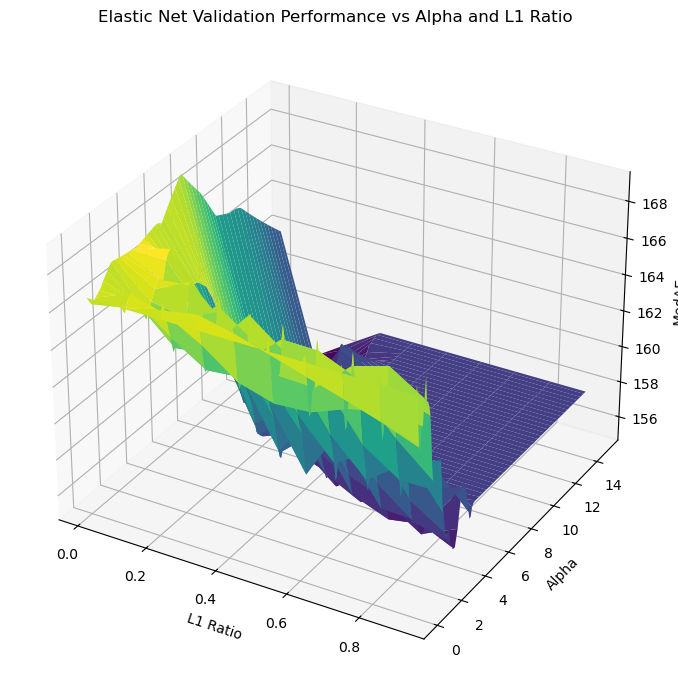

Best alpha: 12.81
Best l1_ratio: 0.21000000000000002
Lowest MedAE: 154.9507


In [48]:
alphas = np.arange(0.01, 15, 0.1)     
l1_ratios = np.arange(0.01, 1.0, 0.1)    

medaeScores = np.zeros((len(alphas), len(l1_ratios)))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, a in enumerate(alphas):
    for j, l1 in enumerate(l1_ratios):
        elasticNet = ElasticNet(alpha=a, l1_ratio=l1)

        foldMedaes = []

        for trainIdx, testIdx in kf.split(logLinearModelsX):
            X_train = logLinearModelsX.iloc[trainIdx]
            X_test = logLinearModelsX.iloc[testIdx]
            y_train = logLinearModelsY.iloc[trainIdx]
            y_test = logLinearModelsY.iloc[testIdx]

            elasticNet.fit(X_train, y_train)
            y_pred_log = elasticNet.predict(X_test)

            y_true = np.expm1(y_test)
            y_pred = np.expm1(y_pred_log)

            foldMedaes.append(median_absolute_error(y_true, y_pred))

        medaeScores[i, j] = np.mean(foldMedaes)

# Find best alpha/l1 combination
best_idx = np.unravel_index(np.argmin(medaeScores), medaeScores.shape)
best_elastic = alphas[best_idx[0]]
best_l1_ratio = l1_ratios[best_idx[1]]
best_medae = medaeScores[best_idx]

alpha_grid, l1_grid = np.meshgrid(l1_ratios, alphas)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, l1_grid, medaeScores, cmap='viridis')
ax.set_xlabel('L1 Ratio')
ax.set_ylabel('Alpha')
ax.set_zlabel('MedAE')
ax.set_title('Elastic Net Validation Performance vs Alpha and L1 Ratio')
plt.tight_layout()
plt.show()

print(f"Best alpha: {best_elastic}")
print(f"Best l1_ratio: {best_l1_ratio}")
print(f"Lowest MedAE: {best_medae:.4f}")

In [49]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(
    z=medae_scores,
    x=l1_ratios,  # X axis (l1_ratio)
    y=alphas      # Y axis (alpha)
)])

fig.update_layout(
    title='ElasticNet RMSLE Surface',
    scene=dict(
        xaxis_title='L1 Ratio',
        yaxis_title='Alpha',
        zaxis_title='RMSLE'
    )
)

fig.show()

### Tuned Model

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
elasticNet = ElasticNet(l1_ratio=best_l1_ratio, alpha=best_elastic)

r2_scores = []
medae_scores = []
medape_scores = []

# predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logLinearModelsX):
    X_train = logLinearModelsX.iloc[trainIdx]
    X_test = logLinearModelsX.iloc[testIdx]
    y_train = logLinearModelsY.iloc[trainIdx]
    y_test = logLinearModelsY.iloc[testIdx]
    
    elasticNet.fit(X_train, y_train) 
    y_pred_log = elasticNet.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)
    
    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print("R² scores:", [round(s, 4) for s in r2_scores])
print("Average R²:", round(np.mean(r2_scores), 4), "")
print("MedAE scores:", [round(s, 2) for s in medae_scores])
print("Average MedAE:", round(np.mean(medae_scores), 2), "hours")
print("MedAPE scores:", [round(s, 2) for s in medape_scores])
print("Average MedAPE:", round(np.mean(medape_scores), 2), "%")

resultsLinearLogTuned.append({
    'Model': 'Elastic Net (Log Transformed Data Tuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

print(elasticNet.get_params())

5-Fold Cross-Validation Metrics:
R² scores: [-0.1879, -0.1508, -0.0358, -0.254, -0.1781]
Average R²: -0.1613 
MedAE scores: [138.44, 158.1, 124.62, 228.31, 125.28]
Average MedAE: 154.95 hours
MedAPE scores: [86.03, 88.22, 117.52, 75.95, 83.95]
Average MedAPE: 90.33 %
{'alpha': 12.81, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.21000000000000002, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [51]:
display(pd.DataFrame(resultsLinearRaw))
display(pd.DataFrame(resultsLinearLogUntuned))
display(pd.DataFrame(resultsLinearLogTuned))
display(pd.DataFrame(resultsnonLinearRaw))
display(pd.DataFrame(resultsnonLinearLogUntuned))
display(pd.DataFrame(resultsnonLinearLogTuned))

,Model,Average R²,Average MedAE,Average MedAPE
0,Linear (Raw Data),-0.047113,332.71567,195.33769
1,Ridge (Raw Data),-0.047113,332.71567,195.33769
2,LASSO (Raw Data),-0.047113,332.71567,195.33769
3,Elastic Net (Raw Data),-0.047113,332.71567,195.33769


,Model,Average R²,Average MedAE,Average MedAPE
0,Linear (Log Transformed Data Untuned),-0.052198,166.556068,87.145834
1,Ridge (Log Transformed Data Untuned),-0.052228,166.546256,87.145619
2,LASSO (Log Transformed Data Untuned),-0.096195,165.335056,86.873321
3,Elastic Net (Log Transformed Data Untuned),-0.076212,164.774574,87.059146


,Model,Average R²,Average MedAE,Average MedAPE
0,Ridge (Log Transformed Data Tuned),-0.054490,166.010039,87.126535
1,LASSO (Log Transformed Data Tuned),-0.165212,156.207931,90.088888
2,Elastic Net (Log Transformed Data Tuned),-0.161305,154.950722,90.334492


,Model,Average R²,Average MedAE,Average MedAPE
0,Random Forest (Raw Data),0.003196,247.165057,143.913725
1,XGBoost (Raw Data),-0.586771,187.858524,114.633889


,Model,Average R²,Average MedAE,Average MedAPE
0,Random Forest (Log Transformed Untuned),0.006778,156.670157,77.789041
1,Random Forest (Log Transformed Tuned),0.011501,133.313064,75.741145
2,XGBoost (Log Transformed Untuned),0.003261,168.194617,90.008202
3,XGBoost (Log Transformed Tuned),0.096142,134.731155,75.879118


""


# Analytical Prediction of Training Time

In [ ]:
processedDataset = mergedDataset.dropna(subset=[
    'Training time (hours)',
    'Training dataset size (datapoints)',
    'Hardware quantity',
    'Parameters',
    'Total Hardware Compute Throughput'
])

#impute missing epoch values with 1
processedDataset['Epochs'] = processedDataset['Epochs'].fillna(1)

# only keep base models
processedDataset = processedDataset[
    (processedDataset['Finetune compute (FLOP)'].isnull() | (processedDataset['Finetune compute (FLOP)'] == 0)) &
    (processedDataset['Base model'].isnull())
]

# only keep language models
processedDataset = processedDataset[
    processedDataset["Domain"].str.contains("Language", case=False, na=False)
]

cols = ['Model', 'Abstract', 'Training compute notes', 'Parameters notes', 'Confidence', 'Domain']

#https://docs.python.org/3/library/re.html
#https://www.w3schools.com/python/python_regex.asp
#https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html

# only keep tranformer models
nonTransformers = ['qrnn', 'lstm', 'rnn', 'gru', 'recurrent', 'conformer', 'tcn', 'cnn', 'T5']
transformerRe = re.compile("|".join(nonTransformers), flags=re.IGNORECASE)
mask = pd.Series(False, index=processedDataset.index)
for col in cols:
    if col in processedDataset.columns:
        mask |= processedDataset[col].astype(str).str.contains(transformerRe, na=False)
processedDataset = processedDataset[~mask]

# only keep dense autoreg models
sparse = ['switch', 'mixture of experts', 'mixture-of-experts','moe', 'gshard', 'multimodal', 'diffusion', 'sparse architecture']
sparseRe = re.compile("|".join(sparse), flags=re.IGNORECASE)
mask = pd.Series(False, index=processedDataset.index)
for col in cols:
    if col in processedDataset.columns:
        mask |= processedDataset[col].astype(str).str.contains(sparseRe, na=False)
processedDataset = processedDataset[~mask]

processedDataset

C:\Users\janvi\AppData\Local\Temp\ipykernel_107772\409743767.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Model,Organization,Publication date,Domain,Task,Parameters,Parameters notes,Training compute (FLOP),Training compute notes,Training dataset,...,Total Tensor Cores,Total Memory,Total Memory Bandwidth,Total Energy (Wh),Total FP16 FLOP/s,Total FP32 FLOP/s,Total Tensor FP16 FLOP/s,Total Hardware Compute Throughput,Effective Total Hardware Compute Throughput,Total Datapoints Processed
64,Llama 3.1-405B,Meta AI,2024-07-23,Language,Language modeling/generation,4.050000e+11,405B,3.800000e+25,"Stated in paper.\n\nAlso, 6 * 405B * 15.6T tra...",Llama 3 dataset,...,8650752.0,1.310720e+15,5.488640e+16,1.958651e+10,2.192179e+18,1.096253e+18,1.621033e+19,1.621033e+19,5.673615e+18,1.560000e+13
72,Nemotron-4 340B,NVIDIA,2024-06-14,Language,"Language modeling/generation,Chat,Question ans...",3.400000e+11,340B,1.800000e+25,9 trillion tokens for training\n6 * 340B * 9T ...,Unspecified unreleased,...,3244032.0,4.915200e+14,2.058240e+16,7.671329e+09,8.220672e+17,4.110950e+17,6.078874e+18,6.078874e+18,2.127606e+18,6.750000e+12
123,Nemotron-3-8B,NVIDIA,2023-11-15,Language,"Chat,Language generation,Language modeling/gen...",8.000000e+09,NaN,1.800000e+23,https://huggingface.co/nvidia/nemotron-3-8b-ba...,"Unspecified unreleased,Flan,P3 (Public Pool of...",...,442368.0,4.096000e+13,1.597440e+15,1.286709e+08,7.984128e+16,1.996800e+16,3.194880e+17,3.194880e+17,1.118208e+17,3.800000e+12
139,Skywork-13B,Kunlun Inc.,2023-10-30,Language,"Language modeling,Language modeling/generation...",1.300000e+10,13B,2.500000e+23,"""Our Skywork-13B is trained on a cluster of 64...",SkyPile,...,221184.0,NaN,7.987200e+14,1.348937e+08,3.992064e+16,9.978880e+15,1.596416e+17,1.596416e+17,5.587456e+16,3.180000e+12
149,Amazon Titan,Amazon,2023-09-28,"Language,Image generation","Semantic search,Image generation,Language mode...",2.000000e+11,200B dense model\nhttps://importai.substack.co...,4.800000e+24,trained using NVIDIA NeMo: https://blogs.nvidi...,NaN,...,5944320.0,5.504000e+14,2.146560e+16,3.394422e+09,1.072867e+18,2.683200e+17,4.293120e+18,4.293120e+18,1.502592e+18,4.000000e+12
154,Falcon-180B,Technology Innovation Institute,2023-09-06,Language,Language modeling,1.800000e+11,"""Falcon 180B is a super-powerful language mode...",3.760000e+24,"43,500 petaflop-days per Table 1 of the paper\...",RefinedWeb,...,1769472.0,1.638400e+14,6.389760e+15,2.660435e+09,3.193651e+17,7.983104e+16,1.277952e+18,1.277952e+18,4.472832e+17,3.500000e+12
162,Llama 2-70B,Meta AI,2023-07-18,Language,Language modeling,7.000000e+10,"Llama has been released in 7B, 13B, 34B, and 7...",8.100000e+23,"""Pretraining utilized a cumulative 3.3M GPU ho...",Llama 2 dataset,...,432000.0,8.000000e+13,2.039000e+15,5.762803e+08,7.797000e+16,1.949000e+16,3.120000e+17,3.120000e+17,1.092000e+17,1.500000e+12
183,StarCoder,"Hugging Face,ServiceNow,Northeastern Universit...",2023-05-09,Language,Code generation,1.550000e+10,"""We trained a 15.5B parameter model""",8.460000e+22,"FLOP reported here, 8.46e22\nhttps://huggingfa...",The Stack,...,221184.0,4.096000e+13,1.043968e+15,5.798597e+07,3.992064e+16,9.978880e+15,1.597440e+17,1.597440e+17,5.591040e+16,1.000000e+12
190,BloombergGPT,"Bloomberg,Johns Hopkins University",2023-03-30,Language,Language modeling,5.055887e+10,NaN,2.360000e+23,2.36e23 per Table 4\n\n(using our usual hardwa...,NaN,...,221184.0,2.048000e+13,7.987200e+14,1.695730e+08,3.992064e+16,9.984000e+15,1.597440e+17,1.597440e+17,5.591040e+16,5.671200e+11
198,Falcon-40B,Technology Innovation Institute,2023-03-15,Language,Language modeling,4.000000e+10,Model comes in 7B and 40B variants.,2.400000e+23,C = 6ND = 6 * 40B * 1000B = 2.4e+23 FLOP (assu...,RefinedWeb,...,165888.0,1.536000e+13,5.990400e+14,1.704555e+08,2.994048e+16,7.488000e+15,1.198080e+17,1.198080e+17,4.193280e+16,1.000000e+12


In [55]:
processedDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 64 to 535
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Model                                         35 non-null     object 
 1   Organization                                  35 non-null     object 
 2   Publication date                              35 non-null     object 
 3   Domain                                        35 non-null     object 
 4   Task                                          35 non-null     object 
 5   Parameters                                    35 non-null     float64
 6   Parameters notes                              30 non-null     object 
 7   Training compute (FLOP)                       35 non-null     float64
 8   Training compute notes                        35 non-null     object 
 9   Training dataset                              29 non-null     object 


In [59]:
trainingTimeEstimate = (
    (6 * processedDataset['Parameters'] * processedDataset['Training dataset size (datapoints)'] * processedDataset['Epochs']) / 
    (processedDataset['Total Hardware Compute Throughput'] * 0.3 * 3600)
).values  

comparison = pd.DataFrame({
    'Model': processedDataset['Model'].values,
    'Estimated Training Time (hrs)': trainingTimeEstimate,
    'Reported Training Time (hrs)': processedDataset['Training time (hours)'].values,
    'Residuals': np.abs(trainingTimeEstimate - processedDataset['Training time (hours)'].values),
    'Residuals (%)': np.abs((trainingTimeEstimate - processedDataset['Training time (hours)'].values) / processedDataset['Training time (hours)'].values) * 100
})

y_true = comparison['Reported Training Time (hrs)']
y_pred = comparison['Estimated Training Time (hrs)']


medae = median_absolute_error(y_true, y_pred)
medape = MedAPE(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

display(comparison)

print(f"Median Absolute Error (MedAE): {medae:.2f} hours")
print(f"Median Absolute Percentage Error (MedAPE): {medape:.2f}%")
#print(f"R² Score: {r2:.4f}")


,Model,Estimated Training Time (hrs),Reported Training Time (hrs),Residuals,Residuals (%)
0,Llama 3.1-405B,2165.286016,2142.0,23.286016,1.087116
1,Nemotron-4 340B,2097.428050,2200.0,102.571950,4.662361
2,Nemotron-3-8B,528.623575,456.0,72.623575,15.926223
3,Skywork-13B,1438.639219,940.0,498.639219,53.046725
4,Amazon Titan,1035.248128,1152.0,116.751872,10.134711
5,Falcon-180B,2738.757011,4320.0,1581.242989,36.602847
6,Llama 2-70B,1869.658120,1728.0,141.658120,8.197808
7,StarCoder,539.056936,625.5,86.443064,13.819834
8,BloombergGPT,997.183879,1270.0,272.816121,21.481584
9,Falcon-40B,1854.819563,1440.0,414.819563,28.806914


Median Absolute Error (MedAE): 141.66 hours
Median Absolute Percentage Error (MedAPE): 25.83%


In [60]:
# obtain models for comparison with bloom study
models = ['BLOOM-176B', 'OPT-175B', 'Gopher (280B)', 'GPT-3 175B (davinci)']
studySubset = comparison[comparison['Model'].isin(models)].copy()
dataSubset = processedDataset[processedDataset['Model'].isin(models)].copy()
#merge model training specs with time estimations
mergedSubset = studySubset.merge(dataSubset[['Model', 'TDP (W)', 'Hardware quantity', 'Hardware utilization']], on='Model', how='left')
mergedSubset['PUE'] = [1.2, 1.09, 1.08, 1.56]
#from patterson et al the GPU energy for a V100 was approximated to be 300W (likely an error on their part but for consistency we will correct this)
mergedSubset['TDP (W)'] = [400, 400, 220, 300] # same values as before but adjust tdp for GPT v110 

mergedSubset['Our Estimated Energy (MWh) (Estimated Pre Training) (Adjusted for PUE)'] = (
    mergedSubset['Estimated Training Time (hrs)'] *
    mergedSubset['TDP (W)'] *
    mergedSubset['Hardware quantity'] *
    mergedSubset['PUE'] 
    / 1e6  
)

##note that hugging face forgot to adjust the estimated energy for their BLOOM model for PUE
mergedSubset['Hugging Face Estimated Energy (MWh) (Estimated Post Training) (Adjusted for PUE)'] = [433 * 1.2, 324, 1066 , 1287]
mergedSubset['Hugging Face Estimated Carbon Emissions (Adjusted for PUE)'] = [30, 76.3, 380, 522]
mergedSubset['Grid CI'] = [57, 231, 330, 429]
#using Hugging Face's Carbon methodology of just multiplying CI by energy usage - not as granualar as this project but done for consistency
mergedSubset['Our Estimated Carbon Emissions (Adjusted for PUE)'] = mergedSubset['Our Estimated Energy (MWh) (Estimated Pre Training) (Adjusted for PUE)'] * mergedSubset['Grid CI'] * 0.001 

mergedSubset[["Model", 
    "Hugging Face Estimated Energy (MWh) (Estimated Post Training) (Adjusted for PUE)", 
    "Our Estimated Energy (MWh) (Estimated Pre Training) (Adjusted for PUE)",
    "Hugging Face Estimated Carbon Emissions (Adjusted for PUE)",
    "Our Estimated Carbon Emissions (Adjusted for PUE)"]]


,Model,Hugging Face Estimated Energy (MWh) (Estimated Post Training) (Adjusted for PUE),Our Estimated Energy (MWh) (Estimated Pre Training) (Adjusted for PUE),Hugging Face Estimated Carbon Emissions (Adjusted for PUE),Our Estimated Carbon Emissions (Adjusted for PUE)
0,BLOOM-176B,519.6,570.920648,30.0,32.542477
1,OPT-175B,324.0,407.593622,76.3,94.154127
2,Gopher (280B),1066.0,901.463415,380.0,297.482927
3,GPT-3 175B (davinci),1287.0,1092.000000,522.0,468.468000


## Test datasubset on XGB and Random Forest for comparison

In [61]:
testSubset = (
    processedDataset.select_dtypes(include=['float'])  # Keep only float columns
      .dropna(axis=1, how='all')                       # Drop columns with all values as NaN
      .drop(columns=['Citations',                      #cannot be found before model is trained
      'Training compute (FLOP)',                       #cannot be found before model is trained
      'Total Energy (Wh)',                             #cannot be found before model is trained
      'Training power draw (W)',                       #cannot be found before model is trained
      'Release price (USD)',                           #cannot be found before model is trained
      'Training compute cost (2023 USD)',              #cannot be found before model is trained
      'Hardware utilization',                          #cannot be found before model is trained
      'FP64 (double precision) performance (FLOP/s)',  #singular hardware performance
      'FP32 (single precision) performance (FLOP/s)',  #singular hardware performance
      'FP16 (half precision) performance (FLOP/s)',    #singular hardware performance
      'TF32 (TensorFloat-32) performance (FLOP/s)',    #singular hardware performance
      'Tensor-FP16/BF16 performance (FLOP/s)',         #singular hardware performance
      'INT8 performance (OP/s)',                       #singular hardware performance
      'Memory size per board (Byte)',                  #singular hardware performance
      'Memory bandwidth (byte/s)',                     #singular hardware performance
      'Intranode bandwidth (byte/s)',                  #singular hardware performance
      'Internode bandwidth (bit/s)',                   #singular hardware performance
      'Die Size (mm^2)',                               #singular hardware performance
      'TDP (W)',                                       #singular hardware performance
      'Base clock (MHz)',                              #singular hardware performance
      'Boost clock (MHz)',                             #singular hardware performance
      'Memory clock (MHz)',                            #singular hardware performance
      'Memory bus (bit)',                              #singular hardware performance
      'Tensor cores',                                  #singular hardware performance - also covered by FLOPS performance
      'Process size (nm)',                             #singular hardware performance
      'Number of transistors (millions)',              #singular hardware performance
      'Total FP16 FLOP/s',                             #included in total hardware compute                      
      'Total FP32 FLOP/s',                             #included in total hardware compute                      
      'Total Tensor FP16 FLOP/s',                       #included in total hardware compute
      'Total Hardware Compute Throughput',               #would like to use effective thoughput
      'Epochs',
      'Training dataset size (datapoints)'
       ]) 
)

In [ ]:
testSubset

,Parameters,Training time (hours),Hardware quantity,Batch size,Total Tensor Cores,Total Memory,Total Memory Bandwidth,Effective Total Hardware Compute Throughput,Total Datapoints Processed
64,4.050000e+11,2142.0,16384.0,16000000.0,8650752.0,1.310720e+15,5.488640e+16,5.673615e+18,1.560000e+13
72,3.400000e+11,2200.0,6144.0,NaN,3244032.0,4.915200e+14,2.058240e+16,2.127606e+18,6.750000e+12
123,8.000000e+09,456.0,1024.0,NaN,442368.0,4.096000e+13,1.597440e+15,1.118208e+17,3.800000e+12
139,1.300000e+10,940.0,512.0,16000000.0,221184.0,NaN,7.987200e+14,5.587456e+16,3.180000e+12
149,2.000000e+11,1152.0,13760.0,NaN,5944320.0,5.504000e+14,2.146560e+16,1.502592e+18,4.000000e+12
154,1.800000e+11,4320.0,4096.0,4194304.0,1769472.0,1.638400e+14,6.389760e+15,4.472832e+17,3.500000e+12
162,7.000000e+10,1728.0,1000.0,4000000.0,432000.0,8.000000e+13,2.039000e+15,1.092000e+17,1.500000e+12
183,1.550000e+10,625.5,512.0,4000000.0,221184.0,4.096000e+13,1.043968e+15,5.591040e+16,1.000000e+12
190,5.055887e+10,1270.0,512.0,4200000.0,221184.0,2.048000e+13,7.987200e+14,5.591040e+16,5.671200e+11
198,4.000000e+10,1440.0,384.0,2359296.0,165888.0,1.536000e+13,5.990400e+14,4.193280e+16,1.000000e+12


In [62]:
rawTrainingDatasetNoImpute

,Parameters,Training time (hours),Effective Total Hardware Compute Throughput,Total Datapoints Processed
3,3.200000e+10,2160.0000,1.773005e+17,1.200000e+10
12,NaN,2400.0000,3.462900e+19,NaN
18,8.930000e+09,130.5000,8.865024e+16,NaN
39,NaN,720.0000,6.925800e+17,NaN
40,NaN,720.0000,1.397760e+16,NaN
...,...,...,...,...
912,1.000000e+04,0.1000,NaN,1.400000e+03
923,3.240000e+02,2.8000,NaN,5.000000e+05
937,NaN,3.0000,NaN,NaN
938,NaN,2.5000,NaN,NaN


## retuning XGBoost on subset (avoiding leakage)

In [63]:
#prep data

subDataset = logTrainingDatasetNoImpute.drop(index=processedIdx)

logXGBoostX = subDataset.drop(columns=['logTrainingTime'])
logXGBoostY = subDataset['logTrainingTime']

#display(logXGBoostX)
#display(logXGBoostY)

#train model and evaluate

xgb_regressor_time = xgb.XGBRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logXGBoostX):
    X_train = logXGBoostX.iloc[trainIdx]
    X_test = logXGBoostX.iloc[testIdx]
    y_train = logXGBoostY.iloc[trainIdx]
    y_test = logXGBoostY.iloc[testIdx]

    xgb_regressor_time.fit(X_train, y_train)
    y_pred_log = xgb_regressor_time.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

def real_medae(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return median_absolute_error(y_true, y_pred)

realMedAE_scorer = make_scorer(real_medae, greater_is_better=False)

# define params grid
#https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/
#https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
#https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
# https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

paramGrid = {
    'n_estimators': [50, 75, 100, 150, 200, 250, 300, 350],       
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, 15],                     
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9],          
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],                   
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.9, 1.0],           
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2, 5],                     
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1, 2, 5]                     
}

xgboost = xgb.XGBRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# set up gridsearch
randomSearch = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=paramGrid,
    scoring=realMedAE_scorer,
    cv=kf,
)

#fit in log space
randomSearch.fit(logXGBoostX, logXGBoostY)

#get best model
bestxgb = randomSearch.best_estimator_
print("Best Hyperparameters:", randomSearch.best_params_)
print("Best Score (MedAE):", -randomSearch.best_score_)

r2_scores = []
medae_scores = []
medape_scores = []

#predict in log space first then exponentiate values - repeat for all folds
for trainIdx, testIdx in kf.split(logXGBoostX):
    X_train = logXGBoostX.iloc[trainIdx]
    X_test = logXGBoostX.iloc[testIdx]
    y_train = logXGBoostY.iloc[trainIdx]
    y_test = logXGBoostY.iloc[testIdx]

    bestxgb.fit(X_train, y_train)
    y_pred_log = bestxgb.predict(X_test)

    y_true = np.expm1(y_test)
    y_pred = np.expm1(y_pred_log)

    r2_scores.append(r2_score(y_true, y_pred))
    medae_scores.append(median_absolute_error(y_true, y_pred))
    medape_scores.append(MedAPE(y_true, y_pred))

print("5-Fold Cross-Validation Metrics:")
print(f"R² scores: {[round(score, 4) for score in r2_scores]}")
print(f"Average R²: {np.mean(r2_scores):.4f}\n")

print(f"MedAE scores: {[round(score, 2) for score in medae_scores]}")
print(f"Average MedAE: {np.mean(medae_scores):.2f} hours")

print(f"MedAPE scores: {[round(score, 2) for score in medape_scores]}")
print(f"Average MedAPE: {np.mean(medape_scores):.2f} %")

resultsnonLinearLogUntuned.append({
    'Model': 'XGBoost (Log Transformed Tuned)',
    'Average R²': np.mean(r2_scores),
    'Average MedAE': np.mean(medae_scores),
    'Average MedAPE': np.mean(medape_scores)
})

#Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

NameError: name 'processedIdx' is not defined

In [ ]:
#get logged subset
processedIdx = processedDataset.index
subset = logTrainingDatasetNoImpute.loc[processedIdx]
subsetlogXGBoostX = subset.drop(columns=['logTrainingTime'])
subsetlogXGBoostY = subset['logTrainingTime']

#predict with xgboost that was trained WITHOUT the testing subset
y_pred_log = bestxgb.predict(subsetlogXGBoostX)

# same as before - convert back to real space
y_true = np.expm1(subsetlogXGBoostY)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
medape = MedAPE(y_true, y_pred)

print("Evaluation on Subset of 38 Models:")
print(f"R²: {r2:.4f}")
print(f"MedAE: {medae:.2f} hours")
print(f"MedAPE: {medape:.2f} %")

resultsnonLinearLogTuned.append({
    'Model': 'XGBoost (Subset Evaluation)',
    'Average R²': r2,
    'Average MedAE': medae,
    'Average MedAPE': medape
})

Evaluation on Subset of 38 Models:
R²: -0.2594
MedAE: 311.19 hours
MedAPE: 64.92 %
